In [240]:
# NattyNatt Rengar Performance Analysis
# Comprehensive statistical analysis of League of Legends match data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
import json
from datetime import datetime

warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ Imports loaded successfully")


✓ Imports loaded successfully


In [241]:
# Load all three datasets
print("Loading datasets...")

matches = pd.read_csv('data/nattynatt_rengar_matches.csv')
frames = pd.read_csv('data/nattynatt_rengar_frames.csv')
events = pd.read_csv('data/nattynatt_rengar_events.csv')

print(f"✓ Matches loaded: {len(matches)} games")
print(f"✓ Frames loaded: {len(frames):,} frame records")
print(f"✓ Events loaded: {len(events):,} events")

# Basic data info
print(f"\nMatch columns: {len(matches.columns)}")
print(f"Frame columns: {len(frames.columns)}")
print(f"Event columns: {len(events.columns)}")

# Convert game_creation to datetime
matches['game_date'] = pd.to_datetime(matches['game_creation'], unit='ms')
matches = matches.sort_values('game_date').reset_index(drop=True)

print("\n✓ Data loaded and preprocessed successfully!")


Loading datasets...
✓ Matches loaded: 317 games
✓ Frames loaded: 80,150 frame records
✓ Events loaded: 309,101 events

Match columns: 117
Frame columns: 23
Event columns: 21

✓ Data loaded and preprocessed successfully!


1. OVERALL PERFORMANCE ANALYSIS

📊 WIN RATE METRICS
────────────────────────────────────────────────────────────
Total Games: 317
Wins: 225 | Losses: 92
Overall Win Rate: 71.0%
95% CI: [65.9%, 76.0%]

📈 Win Rate by Game Duration:
  Early (<20min): 80.0% (90 games)
  Mid (20-30min): 68.6% (185 games)
  Late (30min+): 61.9% (42 games)
Last 10 games: 90.0%
Last 20 games: 85.0%
Last 50 games: 70.0%

🔥 Longest Win Streak: 30 games
❄️  Longest Loss Streak: 4 games


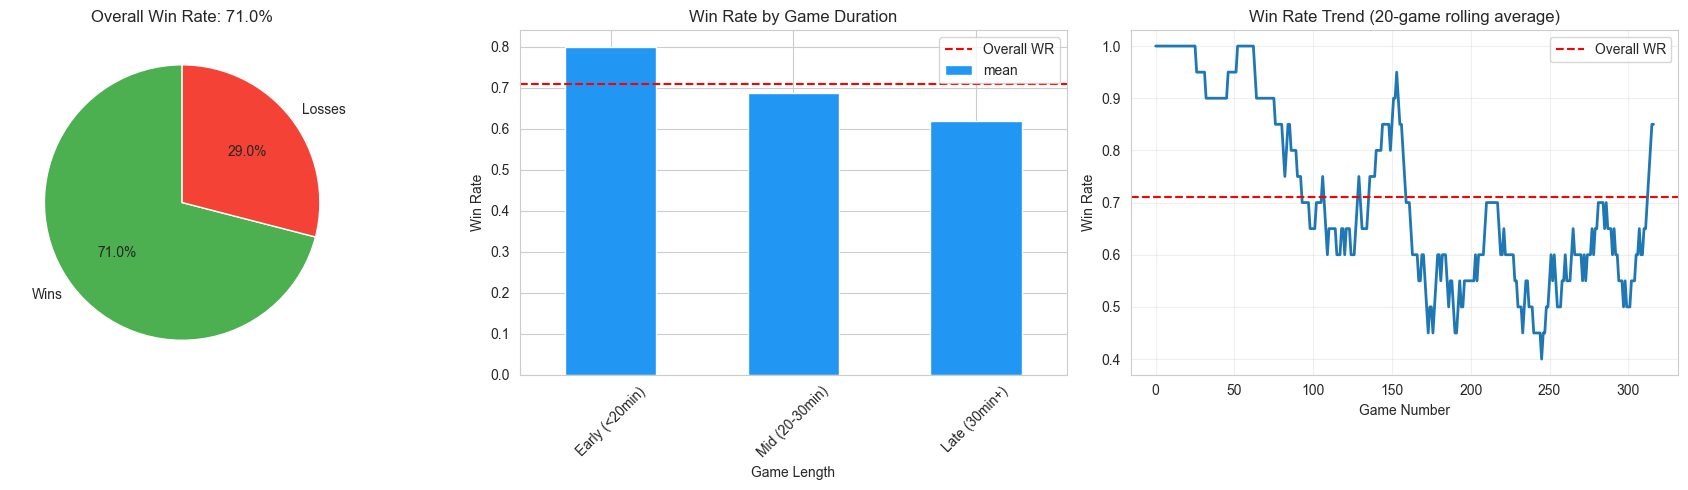


✓ Win rate analysis complete


In [242]:
# ============================================================================
# 1. OVERALL PERFORMANCE ANALYSIS
# ============================================================================

print("="*80)
print("1. OVERALL PERFORMANCE ANALYSIS")
print("="*80)

# Win Rate Metrics
overall_wr = matches['win'].mean()
total_games = len(matches)
wins = matches['win'].sum()
losses = total_games - wins

# Confidence interval for win rate
from scipy.stats import binom
ci = binom.interval(0.95, total_games, overall_wr)
ci_lower, ci_upper = ci[0] / total_games, ci[1] / total_games

print(f"\n📊 WIN RATE METRICS")
print(f"{'─'*60}")
print(f"Total Games: {total_games}")
print(f"Wins: {wins} | Losses: {losses}")
print(f"Overall Win Rate: {overall_wr:.1%}")
print(f"95% CI: [{ci_lower:.1%}, {ci_upper:.1%}]")

# Win rate by game duration buckets
matches['duration_min'] = matches['game_duration'] / 60
matches['game_length_bucket'] = pd.cut(matches['duration_min'], 
                                        bins=[0, 20, 30, 100], 
                                        labels=['Early (<20min)', 'Mid (20-30min)', 'Late (30min+)'])

wr_by_duration = matches.groupby('game_length_bucket')['win'].agg(['mean', 'count'])
print(f"\n📈 Win Rate by Game Duration:")
for bucket, row in wr_by_duration.iterrows():
    print(f"  {bucket}: {row['mean']:.1%} ({int(row['count'])} games)")

# Recent performance trends
for n in [10, 20, 50]:
    recent_wr = matches.tail(n)['win'].mean()
    print(f"Last {n} games: {recent_wr:.1%}")

# Win streaks
matches['streak'] = (matches['win'] != matches['win'].shift()).cumsum()
streaks = matches.groupby('streak').agg({
    'win': ['first', 'count']
}).reset_index()
streaks.columns = ['streak_id', 'is_win', 'length']

longest_win_streak = streaks[streaks['is_win']]['length'].max()
longest_loss_streak = streaks[~streaks['is_win']]['length'].max()

print(f"\n🔥 Longest Win Streak: {longest_win_streak} games")
print(f"❄️  Longest Loss Streak: {longest_loss_streak} games")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Win/Loss pie chart
axes[0].pie([wins, losses], labels=['Wins', 'Losses'], autopct='%1.1f%%', 
            colors=['#4CAF50', '#F44336'], startangle=90)
axes[0].set_title(f'Overall Win Rate: {overall_wr:.1%}')

# Win rate by duration
wr_by_duration['mean'].plot(kind='bar', ax=axes[1], color='#2196F3')
axes[1].set_title('Win Rate by Game Duration')
axes[1].set_ylabel('Win Rate')
axes[1].set_xlabel('Game Length')
axes[1].axhline(y=overall_wr, color='r', linestyle='--', label='Overall WR')
axes[1].legend()
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

# Win rate over time (rolling 20 games)
matches['rolling_wr'] = matches['win'].rolling(window=20, min_periods=1).mean()
axes[2].plot(matches.index, matches['rolling_wr'], linewidth=2)
axes[2].axhline(y=overall_wr, color='r', linestyle='--', label='Overall WR')
axes[2].set_title('Win Rate Trend (20-game rolling average)')
axes[2].set_xlabel('Game Number')
axes[2].set_ylabel('Win Rate')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Win rate analysis complete")



KDA ANALYSIS

📊 KDA Statistics:
  Mean KDA: 5.69
  Median KDA: 4.50
  Std Dev: 5.03
  Mean Kills: 9.82
  Mean Deaths: 4.34
  Mean Assists: 6.14

📈 KDA by Outcome:
       kills  deaths  assists   kda
win                                
False   5.79    6.42     4.28  1.57
True   11.47    3.49     6.89  7.37


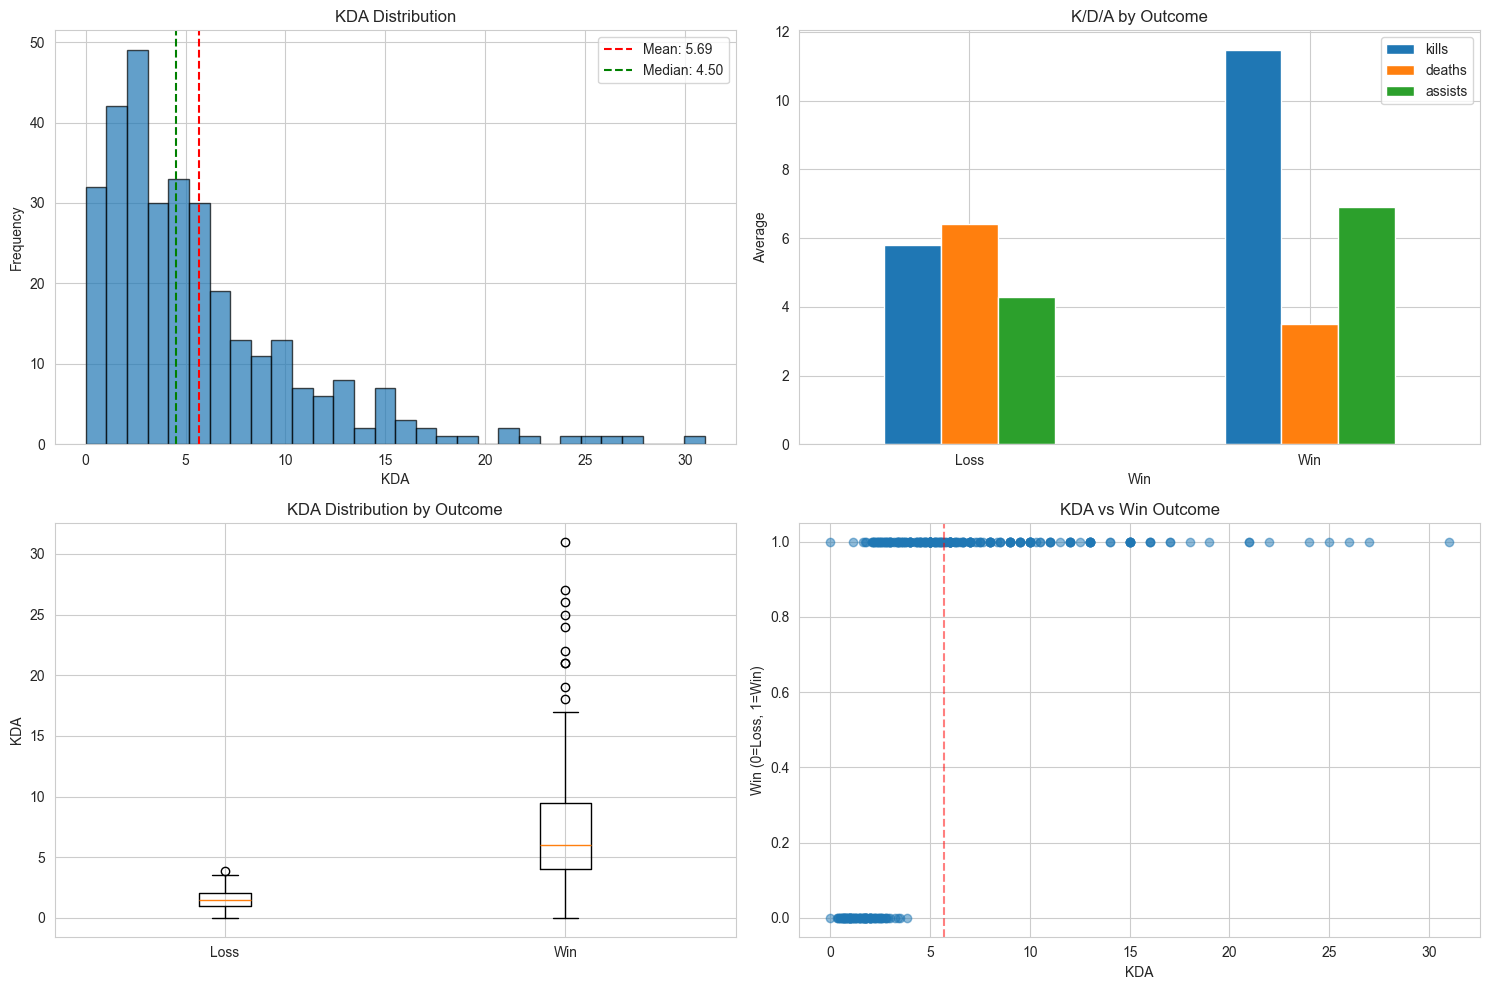


✓ KDA analysis complete


In [243]:
# KDA Analysis
print(f"\n{'='*80}")
print("KDA ANALYSIS")
print(f"{'='*80}")

# Calculate KDA
matches['kda'] = (matches['kills'] + matches['assists']) / matches['deaths'].replace(0, 1)

# Statistics
kda_stats = {
    'Mean KDA': matches['kda'].mean(),
    'Median KDA': matches['kda'].median(),
    'Std Dev': matches['kda'].std(),
    'Mean Kills': matches['kills'].mean(),
    'Mean Deaths': matches['deaths'].mean(),
    'Mean Assists': matches['assists'].mean()
}

print(f"\n📊 KDA Statistics:")
for key, val in kda_stats.items():
    print(f"  {key}: {val:.2f}")

# KDA by outcome
kda_by_outcome = matches.groupby('win')[['kills', 'deaths', 'assists', 'kda']].mean()
print(f"\n📈 KDA by Outcome:")
print(kda_by_outcome.round(2))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# KDA distribution
axes[0, 0].hist(matches['kda'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(matches['kda'].mean(), color='r', linestyle='--', label=f'Mean: {matches["kda"].mean():.2f}')
axes[0, 0].axvline(matches['kda'].median(), color='g', linestyle='--', label=f'Median: {matches["kda"].median():.2f}')
axes[0, 0].set_title('KDA Distribution')
axes[0, 0].set_xlabel('KDA')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# K/D/A by outcome
kda_by_outcome[['kills', 'deaths', 'assists']].plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('K/D/A by Outcome')
axes[0, 1].set_xlabel('Win')
axes[0, 1].set_ylabel('Average')
axes[0, 1].set_xticklabels(['Loss', 'Win'], rotation=0)
axes[0, 1].legend()

# Box plots
data_to_plot = [matches[matches['win']==False]['kda'], matches[matches['win']==True]['kda']]
axes[1, 0].boxplot(data_to_plot, labels=['Loss', 'Win'])
axes[1, 0].set_title('KDA Distribution by Outcome')
axes[1, 0].set_ylabel('KDA')

# Scatter: KDA vs Win
axes[1, 1].scatter(matches['kda'], matches['win'], alpha=0.5)
axes[1, 1].set_title('KDA vs Win Outcome')
axes[1, 1].set_xlabel('KDA')
axes[1, 1].set_ylabel('Win (0=Loss, 1=Win)')
axes[1, 1].axvline(matches['kda'].mean(), color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("\n✓ KDA analysis complete")



ECONOMY & DAMAGE METRICS

📊 Economy Statistics:
       gold_earned  cs_per_min  damage_dealt
count       317.00      317.00        317.00
mean      12695.72        8.05      22098.56
std        3946.78        1.09      11769.12
min         514.00        0.00          0.00
25%        9663.00        7.41      12880.00
50%       12746.00        8.10      20516.00
75%       15658.00        8.77      30060.00
max       22859.00       11.12      72103.00

💰 Average Gold by Outcome:
       gold_at_5min  gold_at_10min  gold_at_15min  gold_at_20min
win                                                             
False        1814.0         3775.0         6072.0         8738.0
True         1991.0         4360.0         7343.0        10512.0

⚔️  Damage per Gold: 1.63
   Wins: 1.70
   Losses: 1.45


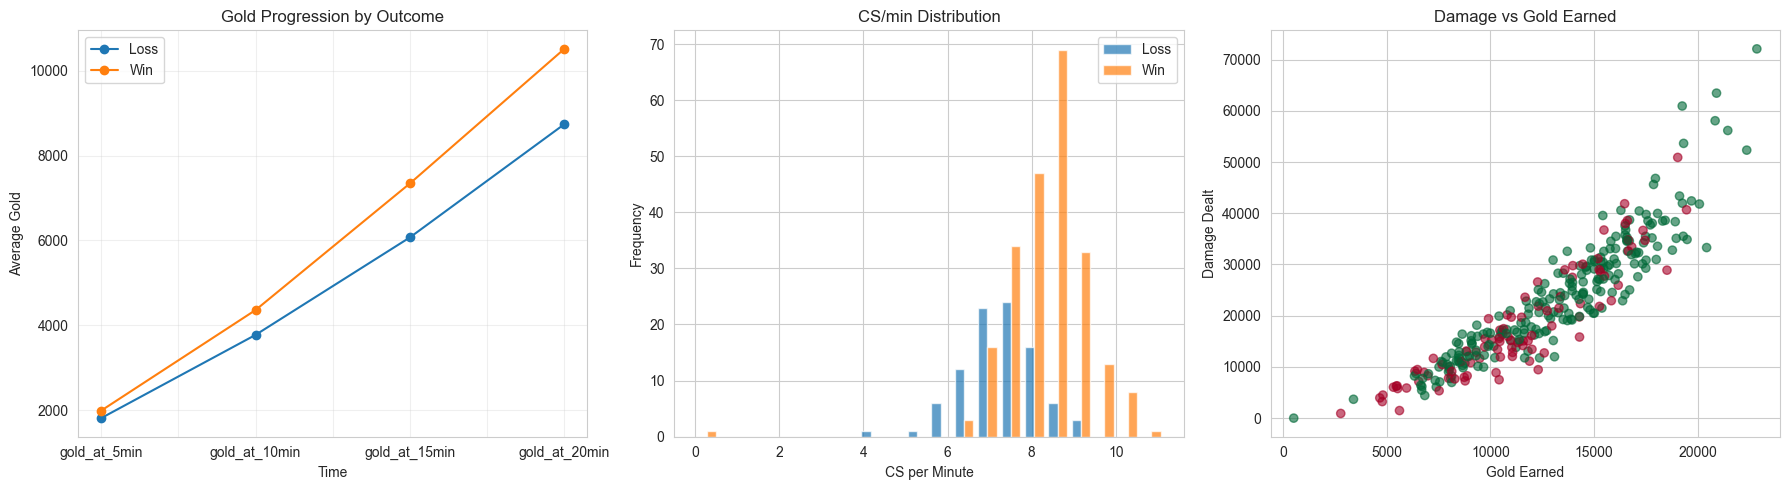


✓ Economy & damage analysis complete


In [244]:
# Economy & Damage Metrics
print(f"\n{'='*80}")
print("ECONOMY & DAMAGE METRICS")
print(f"{'='*80}")

economy_stats = matches[['gold_earned', 'cs_per_min', 'damage_dealt']].describe()
print("\n📊 Economy Statistics:")
print(economy_stats.round(2))

# Gold at intervals
gold_cols = ['gold_at_5min', 'gold_at_10min', 'gold_at_15min', 'gold_at_20min']
gold_by_outcome = matches.groupby('win')[gold_cols].mean()

print(f"\n💰 Average Gold by Outcome:")
print(gold_by_outcome.round(0))

# Damage efficiency
matches['damage_per_gold'] = matches['damage_dealt'] / matches['gold_earned']
print(f"\n⚔️  Damage per Gold: {matches['damage_per_gold'].mean():.2f}")
print(f"   Wins: {matches[matches['win']==True]['damage_per_gold'].mean():.2f}")
print(f"   Losses: {matches[matches['win']==False]['damage_per_gold'].mean():.2f}")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gold progression
gold_by_outcome.T.plot(ax=axes[0], marker='o')
axes[0].set_title('Gold Progression by Outcome')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Average Gold')
axes[0].legend(['Loss', 'Win'])
axes[0].grid(True, alpha=0.3)

# CS distribution
axes[1].hist([matches[matches['win']==False]['cs_per_min'], 
              matches[matches['win']==True]['cs_per_min']], 
             label=['Loss', 'Win'], bins=20, alpha=0.7)
axes[1].set_title('CS/min Distribution')
axes[1].set_xlabel('CS per Minute')
axes[1].set_ylabel('Frequency')
axes[1].legend()

# Damage vs Gold
axes[2].scatter(matches['gold_earned'], matches['damage_dealt'], 
                c=matches['win'], cmap='RdYlGn', alpha=0.6)
axes[2].set_title('Damage vs Gold Earned')
axes[2].set_xlabel('Gold Earned')
axes[2].set_ylabel('Damage Dealt')

plt.tight_layout()
plt.show()

print("\n✓ Economy & damage analysis complete")



2. MATCHUP ANALYSIS

📊 Matchup Statistics (Top 10 by games played):
              Win Rate  Games  Avg Kills  Avg Deaths  Avg Assists  Gold@10  \
enemy_jungle                                                                 
Evelynn           1.00      4      12.00        3.75        10.00  4305.25   
RekSai            1.00      4      13.50        2.25         5.25  4260.00   
Naafiri           1.00      4       9.00        1.50         5.25  4097.25   
Pantheon          1.00      4      15.00        3.00         8.25  4895.00   
JarvanIV          0.94     16       9.31        3.38         6.75  4121.06   
Trundle           0.88      8      10.12        5.12        10.62  4231.50   
Vi                0.86      7      11.00        3.29         6.71  4334.86   
XinZhao           0.81     21       9.86        3.76         6.48  4424.71   
Karthus           0.80      5      15.40        6.80         9.60  4878.20   
Zyra              0.75      8      10.12        4.25         5.00  3962.0

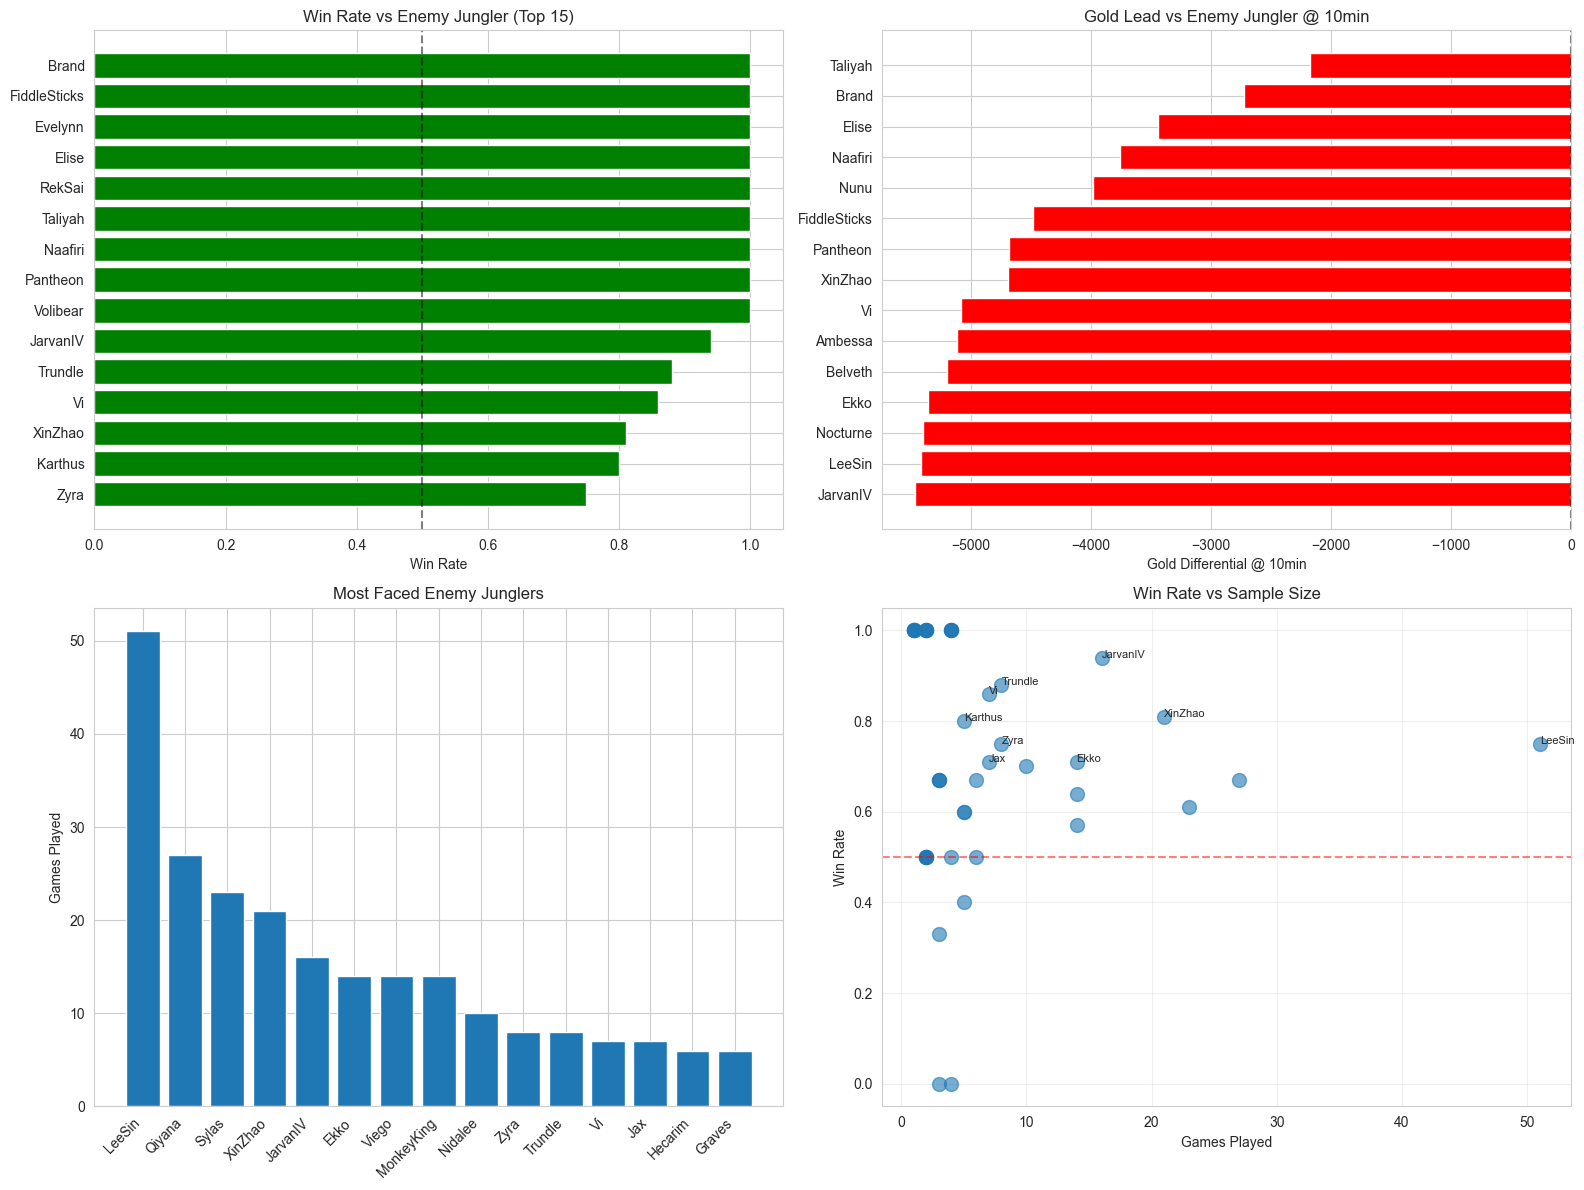


✓ Matchup analysis complete


In [245]:
# ============================================================================
# 2. MATCHUP ANALYSIS
# ============================================================================

print(f"\n{'='*80}")
print("2. MATCHUP ANALYSIS")
print(f"{'='*80}")

# Win rate vs each enemy jungler
matchup_stats = matches.groupby('enemy_jungle').agg({
    'win': ['mean', 'count'],
    'kills': 'mean',
    'deaths': 'mean',
    'assists': 'mean',
    'gold_at_10min': 'mean',
    'enemy_jungle_gold': 'mean'
}).round(2)

matchup_stats.columns = ['Win Rate', 'Games', 'Avg Kills', 'Avg Deaths', 'Avg Assists', 'Gold@10', 'Enemy Gold@10']
matchup_stats['Gold Diff@10'] = matchup_stats['Gold@10'] - matchup_stats['Enemy Gold@10']
matchup_stats = matchup_stats.sort_values('Win Rate', ascending=False)

print(f"\n📊 Matchup Statistics (Top 10 by games played):")
top_matchups = matchup_stats[matchup_stats['Games'] >= 3].head(10)
print(top_matchups)

# Best and worst matchups
best_matchups = matchup_stats[matchup_stats['Games'] >= 3].head(5)
worst_matchups = matchup_stats[matchup_stats['Games'] >= 3].tail(5)

print(f"\n✅ Best Matchups:")
for idx, row in best_matchups.iterrows():
    print(f"  vs {idx}: {row['Win Rate']:.1%} WR ({int(row['Games'])} games)")

print(f"\n❌ Worst Matchups:")
for idx, row in worst_matchups.iterrows():
    print(f"  vs {idx}: {row['Win Rate']:.1%} WR ({int(row['Games'])} games)")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Win rate by matchup (top 15)
top_15 = matchup_stats[matchup_stats['Games'] >= 2].head(15)
axes[0, 0].barh(range(len(top_15)), top_15['Win Rate'], color=['green' if x > 0.5 else 'red' for x in top_15['Win Rate']])
axes[0, 0].set_yticks(range(len(top_15)))
axes[0, 0].set_yticklabels(top_15.index)
axes[0, 0].set_xlabel('Win Rate')
axes[0, 0].set_title('Win Rate vs Enemy Jungler (Top 15)')
axes[0, 0].axvline(x=0.5, color='black', linestyle='--', alpha=0.5)
axes[0, 0].invert_yaxis()

# Gold differential at 10 min
top_15_gold = matchup_stats[matchup_stats['Games'] >= 2].sort_values('Gold Diff@10', ascending=False).head(15)
axes[0, 1].barh(range(len(top_15_gold)), top_15_gold['Gold Diff@10'], 
                color=['green' if x > 0 else 'red' for x in top_15_gold['Gold Diff@10']])
axes[0, 1].set_yticks(range(len(top_15_gold)))
axes[0, 1].set_yticklabels(top_15_gold.index)
axes[0, 1].set_xlabel('Gold Differential @ 10min')
axes[0, 1].set_title('Gold Lead vs Enemy Jungler @ 10min')
axes[0, 1].axvline(x=0, color='black', linestyle='--', alpha=0.5)
axes[0, 1].invert_yaxis()

# Games played per matchup
matchup_counts = matchup_stats.sort_values('Games', ascending=False).head(15)
axes[1, 0].bar(range(len(matchup_counts)), matchup_counts['Games'])
axes[1, 0].set_xticks(range(len(matchup_counts)))
axes[1, 0].set_xticklabels(matchup_counts.index, rotation=45, ha='right')
axes[1, 0].set_ylabel('Games Played')
axes[1, 0].set_title('Most Faced Enemy Junglers')

# Win rate vs games played scatter
axes[1, 1].scatter(matchup_stats['Games'], matchup_stats['Win Rate'], s=100, alpha=0.6)
axes[1, 1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Games Played')
axes[1, 1].set_ylabel('Win Rate')
axes[1, 1].set_title('Win Rate vs Sample Size')
axes[1, 1].grid(True, alpha=0.3)

# Annotate outliers
for idx, row in matchup_stats.iterrows():
    if row['Games'] >= 5 and (row['Win Rate'] > 0.7 or row['Win Rate'] < 0.3):
        axes[1, 1].annotate(idx, (row['Games'], row['Win Rate']), fontsize=8)

plt.tight_layout()
plt.show()

print("\n✓ Matchup analysis complete")



3. EARLY GAME PERFORMANCE

📊 Average CS (First 5 Minutes):
       cs_at_1min  cs_at_2min  cs_at_3min  cs_at_4min  cs_at_5min
win                                                              
False         0.0         3.8        16.0        25.2        31.2
True          0.0         4.0        16.7        25.4        31.5

💰 Gold at 5 Minutes:
       count    mean    std     min     25%     50%     75%     max
win                                                                
False   92.0  1814.0  250.0  1411.0  1659.0  1736.0  1964.0  2862.0
True   224.0  1991.0  313.0  1298.0  1733.0  1963.0  2186.0  3016.0

📈 Level at 5 Minutes:
  Mode: 4.0
  Mean: 4.25
  Distribution: {3.0: 6, 4.0: 225, 5.0: 85}

⚔️  First Gank Timing (seconds):
  Mean: 222.1s (3.7 min)
  Median: 240.1s
  Std Dev: 42.2s

🎯 Ganks by 5 Minutes:
  Wins: 0.92
  Losses: 0.41


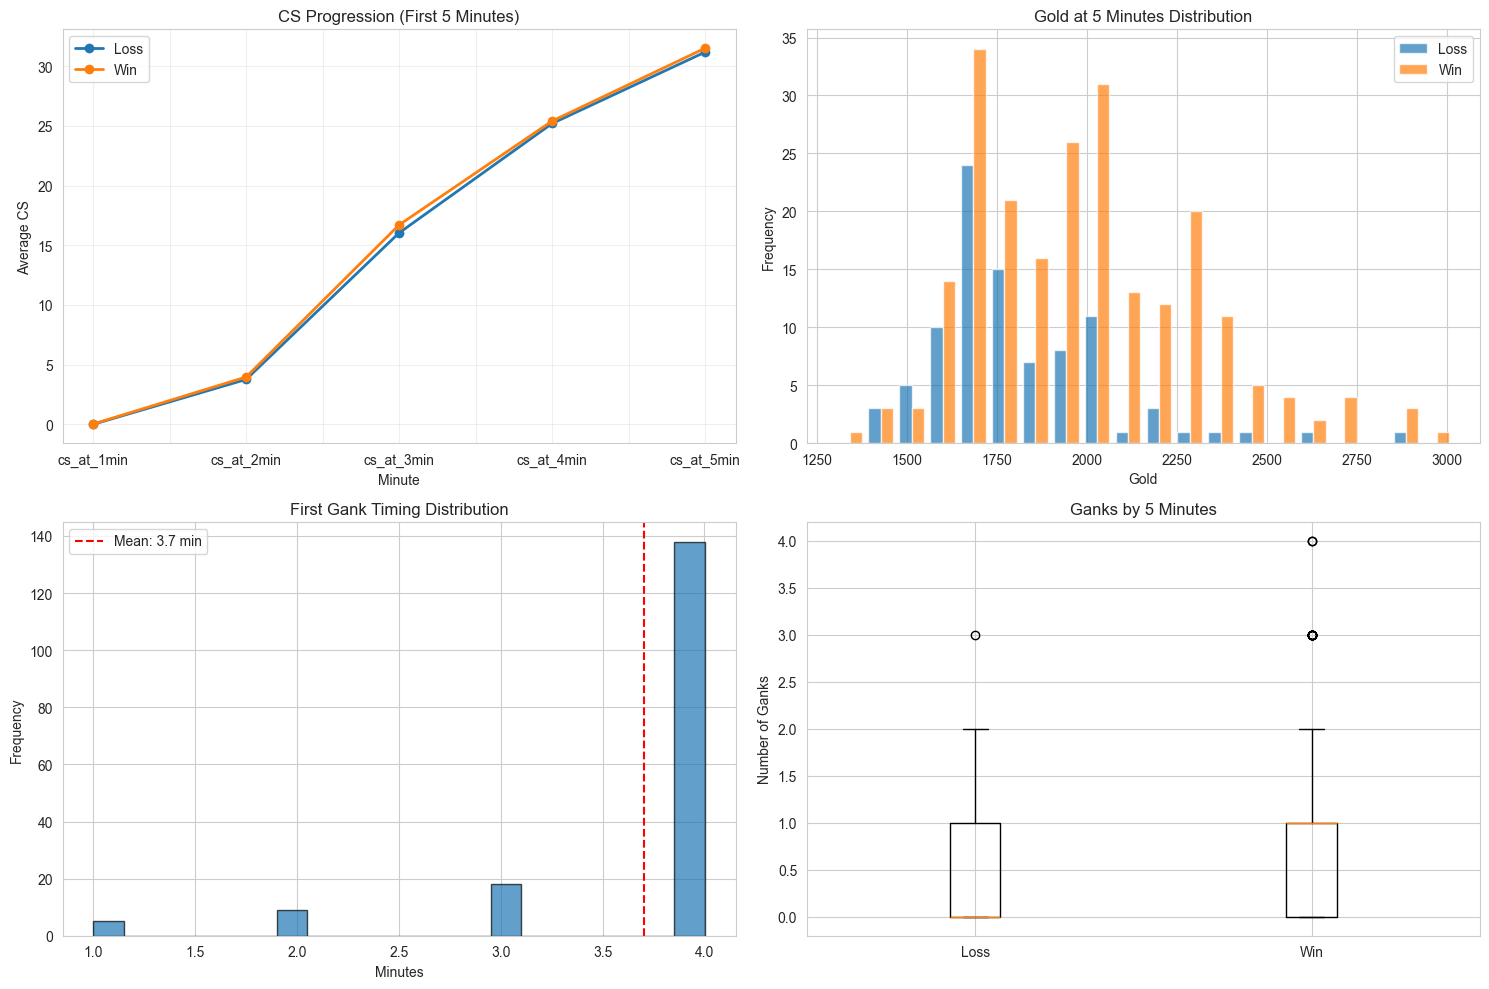


✓ Early game analysis complete


In [246]:
# ============================================================================
# 3. EARLY GAME PERFORMANCE
# ============================================================================

print(f"\n{'='*80}")
print("3. EARLY GAME PERFORMANCE")
print(f"{'='*80}")

# CS at early minutes
cs_cols = ['cs_at_1min', 'cs_at_2min', 'cs_at_3min', 'cs_at_4min', 'cs_at_5min']
early_cs_by_outcome = matches.groupby('win')[cs_cols].mean()

print(f"\n📊 Average CS (First 5 Minutes):")
print(early_cs_by_outcome.round(1))

# Gold at 5 minutes
gold_5_stats = matches.groupby('win')['gold_at_5min'].describe()
print(f"\n💰 Gold at 5 Minutes:")
print(gold_5_stats.round(0))

# Level at 5 minutes
level_5_mode = matches['level_at_5min'].mode()[0] if len(matches['level_at_5min'].mode()) > 0 else None
print(f"\n📈 Level at 5 Minutes:")
print(f"  Mode: {level_5_mode}")
print(f"  Mean: {matches['level_at_5min'].mean():.2f}")
print(f"  Distribution: {matches['level_at_5min'].value_counts().sort_index().to_dict()}")

# First gank timing
first_gank_stats = matches['first_gank_time'].dropna().describe()
print(f"\n⚔️  First Gank Timing (seconds):")
print(f"  Mean: {first_gank_stats['mean']:.1f}s ({first_gank_stats['mean']/60:.1f} min)")
print(f"  Median: {first_gank_stats['50%']:.1f}s")
print(f"  Std Dev: {first_gank_stats['std']:.1f}s")

# Ganks by 5 min
ganks_5min_stats = matches.groupby('win')['ganks_by_5min'].mean()
print(f"\n🎯 Ganks by 5 Minutes:")
print(f"  Wins: {ganks_5min_stats[True]:.2f}")
print(f"  Losses: {ganks_5min_stats[False]:.2f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# CS progression first 5 minutes
early_cs_by_outcome.T.plot(ax=axes[0, 0], marker='o', linewidth=2)
axes[0, 0].set_title('CS Progression (First 5 Minutes)')
axes[0, 0].set_xlabel('Minute')
axes[0, 0].set_ylabel('Average CS')
axes[0, 0].legend(['Loss', 'Win'])
axes[0, 0].grid(True, alpha=0.3)

# Gold at 5 min distribution
axes[0, 1].hist([matches[matches['win']==False]['gold_at_5min'].dropna(), 
                 matches[matches['win']==True]['gold_at_5min'].dropna()], 
                label=['Loss', 'Win'], bins=20, alpha=0.7)
axes[0, 1].set_title('Gold at 5 Minutes Distribution')
axes[0, 1].set_xlabel('Gold')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# First gank timing
axes[1, 0].hist(matches['first_gank_time'].dropna() / 60, bins=20, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(matches['first_gank_time'].mean() / 60, color='r', linestyle='--', 
                   label=f'Mean: {matches["first_gank_time"].mean()/60:.1f} min')
axes[1, 0].set_title('First Gank Timing Distribution')
axes[1, 0].set_xlabel('Minutes')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# Ganks by 5 min
ganks_data = [matches[matches['win']==False]['ganks_by_5min'], 
              matches[matches['win']==True]['ganks_by_5min']]
axes[1, 1].boxplot(ganks_data, labels=['Loss', 'Win'])
axes[1, 1].set_title('Ganks by 5 Minutes')
axes[1, 1].set_ylabel('Number of Ganks')

plt.tight_layout()
plt.show()

print("\n✓ Early game analysis complete")



4. OBJECTIVE CONTROL ANALYSIS

🐉 Dragon Statistics:
  Mean: 1.58 per game
  Median: 2
  Max: 4

📈 Win Rate by Dragons Killed:
  0 dragons: 20.8% (53 games)
  1 dragons: 69.4% (98 games)
  2 dragons: 82.9% (105 games)
  3 dragons: 96.2% (52 games)
  4 dragons: 100.0% (9 games)

🦀 Herald Take Rate: 37.9%
🐛 Baron Take Rate: 19.2%
   Herald avg timing: 1034s (17.2 min)

🏰 Turrets Killed:
  Wins: 1.85
  Losses: 0.54

🎯 First Turret Participation: 33.4%


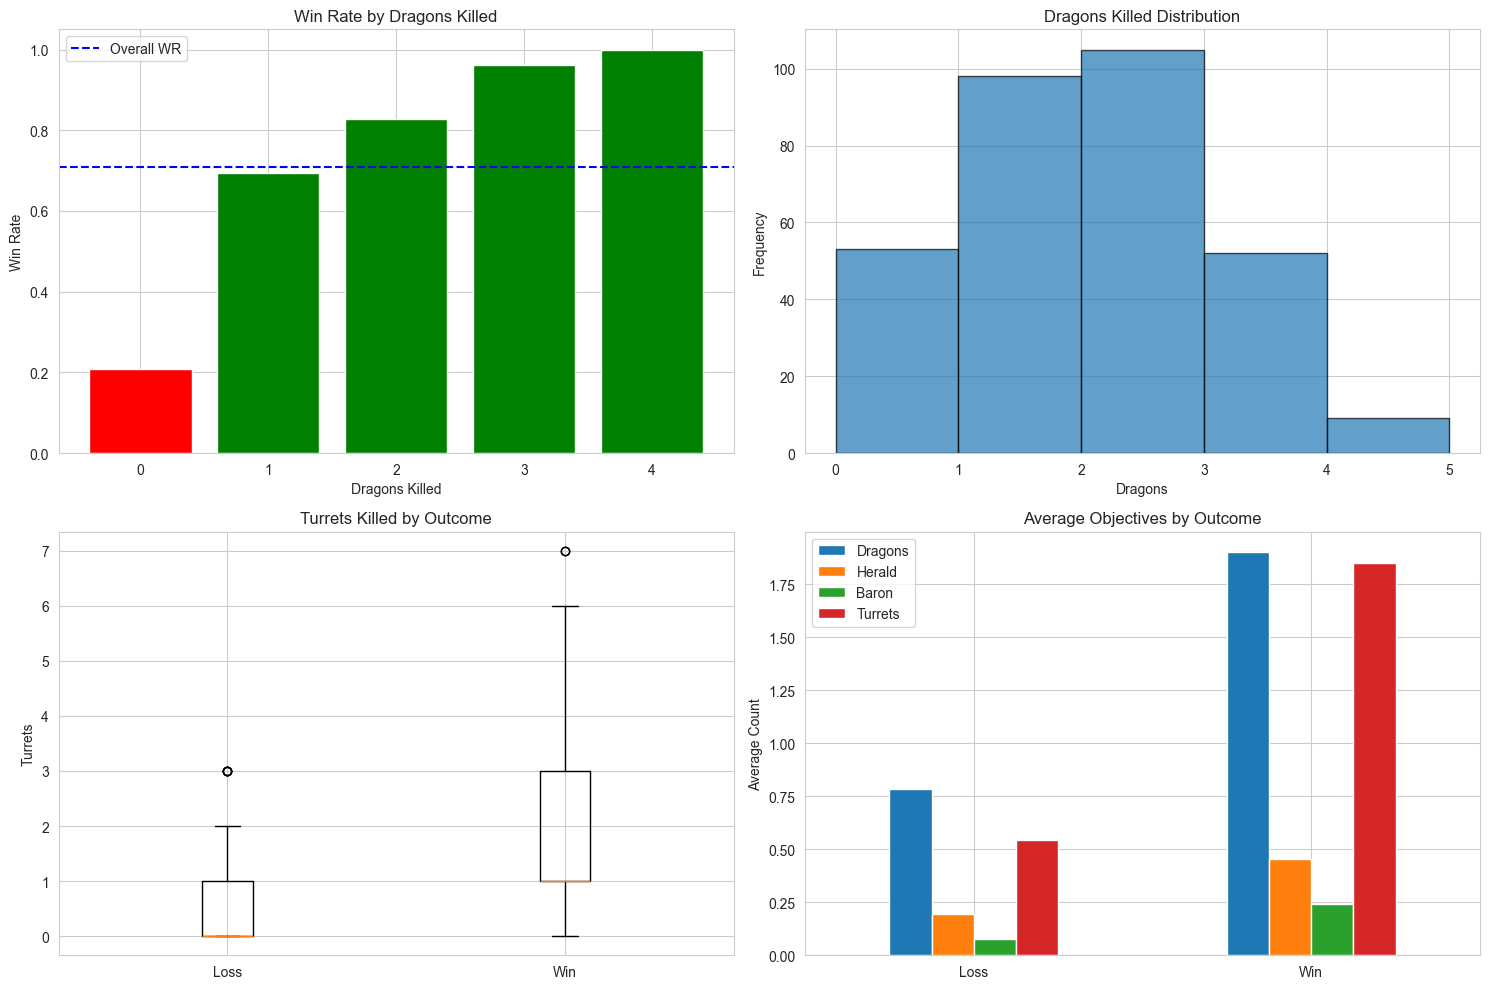


✓ Objective control analysis complete


In [247]:
# ============================================================================
# 4. OBJECTIVE CONTROL ANALYSIS
# ============================================================================

print(f"\n{'='*80}")
print("4. OBJECTIVE CONTROL ANALYSIS")
print(f"{'='*80}")

# Dragon statistics
dragon_stats = matches['dragons_killed'].describe()
print(f"\n🐉 Dragon Statistics:")
print(f"  Mean: {dragon_stats['mean']:.2f} per game")
print(f"  Median: {dragon_stats['50%']:.0f}")
print(f"  Max: {int(dragon_stats['max'])}")

# Win rate by dragons
dragon_wr = matches.groupby('dragons_killed')['win'].agg(['mean', 'count'])
print(f"\n📈 Win Rate by Dragons Killed:")
for drags, row in dragon_wr.iterrows():
    if row['count'] >= 5:
        print(f"  {int(drags)} dragons: {row['mean']:.1%} ({int(row['count'])} games)")

# Herald & Baron
herald_rate = matches['herald_killed'].mean()
baron_rate = matches['baron_killed'].mean()
print(f"\n🦀 Herald Take Rate: {herald_rate:.1%}")
print(f"🐛 Baron Take Rate: {baron_rate:.1%}")

# Herald timing
herald_timing = matches[matches['herald_killed'] > 0]['herald_time'].dropna()
if len(herald_timing) > 0:
    print(f"   Herald avg timing: {herald_timing.mean():.0f}s ({herald_timing.mean()/60:.1f} min)")

# Turrets
turret_stats = matches.groupby('win')['turrets_killed'].mean()
print(f"\n🏰 Turrets Killed:")
print(f"  Wins: {turret_stats[True]:.2f}")
print(f"  Losses: {turret_stats[False]:.2f}")

# First turret participation
first_turret_rate = matches['first_turret'].mean()
print(f"\n🎯 First Turret Participation: {first_turret_rate:.1%}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Win rate by dragons
dragon_wr_filtered = dragon_wr[dragon_wr['count'] >= 5]
axes[0, 0].bar(dragon_wr_filtered.index, dragon_wr_filtered['mean'], 
               color=['red' if x < 0.5 else 'green' for x in dragon_wr_filtered['mean']])
axes[0, 0].axhline(y=overall_wr, color='blue', linestyle='--', label='Overall WR')
axes[0, 0].set_title('Win Rate by Dragons Killed')
axes[0, 0].set_xlabel('Dragons Killed')
axes[0, 0].set_ylabel('Win Rate')
axes[0, 0].legend()

# Dragon distribution
axes[0, 1].hist(matches['dragons_killed'], bins=range(0, int(matches['dragons_killed'].max())+2), 
                edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Dragons Killed Distribution')
axes[0, 1].set_xlabel('Dragons')
axes[0, 1].set_ylabel('Frequency')

# Turrets by outcome
turret_data = [matches[matches['win']==False]['turrets_killed'], 
               matches[matches['win']==True]['turrets_killed']]
axes[1, 0].boxplot(turret_data, labels=['Loss', 'Win'])
axes[1, 0].set_title('Turrets Killed by Outcome')
axes[1, 0].set_ylabel('Turrets')

# Objective summary
obj_summary = pd.DataFrame({
    'Dragons': [matches[matches['win']==False]['dragons_killed'].mean(), 
                matches[matches['win']==True]['dragons_killed'].mean()],
    'Herald': [matches[matches['win']==False]['herald_killed'].mean(), 
               matches[matches['win']==True]['herald_killed'].mean()],
    'Baron': [matches[matches['win']==False]['baron_killed'].mean(), 
              matches[matches['win']==True]['baron_killed'].mean()],
    'Turrets': [matches[matches['win']==False]['turrets_killed'].mean(), 
                matches[matches['win']==True]['turrets_killed'].mean()]
}, index=['Loss', 'Win'])

obj_summary.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Average Objectives by Outcome')
axes[1, 1].set_ylabel('Average Count')
axes[1, 1].set_xticklabels(['Loss', 'Win'], rotation=0)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\n✓ Objective control analysis complete")



5. BUILD & RUNES ANALYSIS

🔑 Keystone Usage:
  8010: 70.9% WR (313 games)
  8021: 75.0% WR (4 games)

🌳 Primary Rune Tree:
  8000: 71.0% WR (317 games)

👁️  Control Wards Purchased:
  Mean: 1.83
  Median: 2
  Wins: 1.94
  Losses: 1.58

✨ Most Common Summoner Spell Combos:
  (4, 11): 317 games


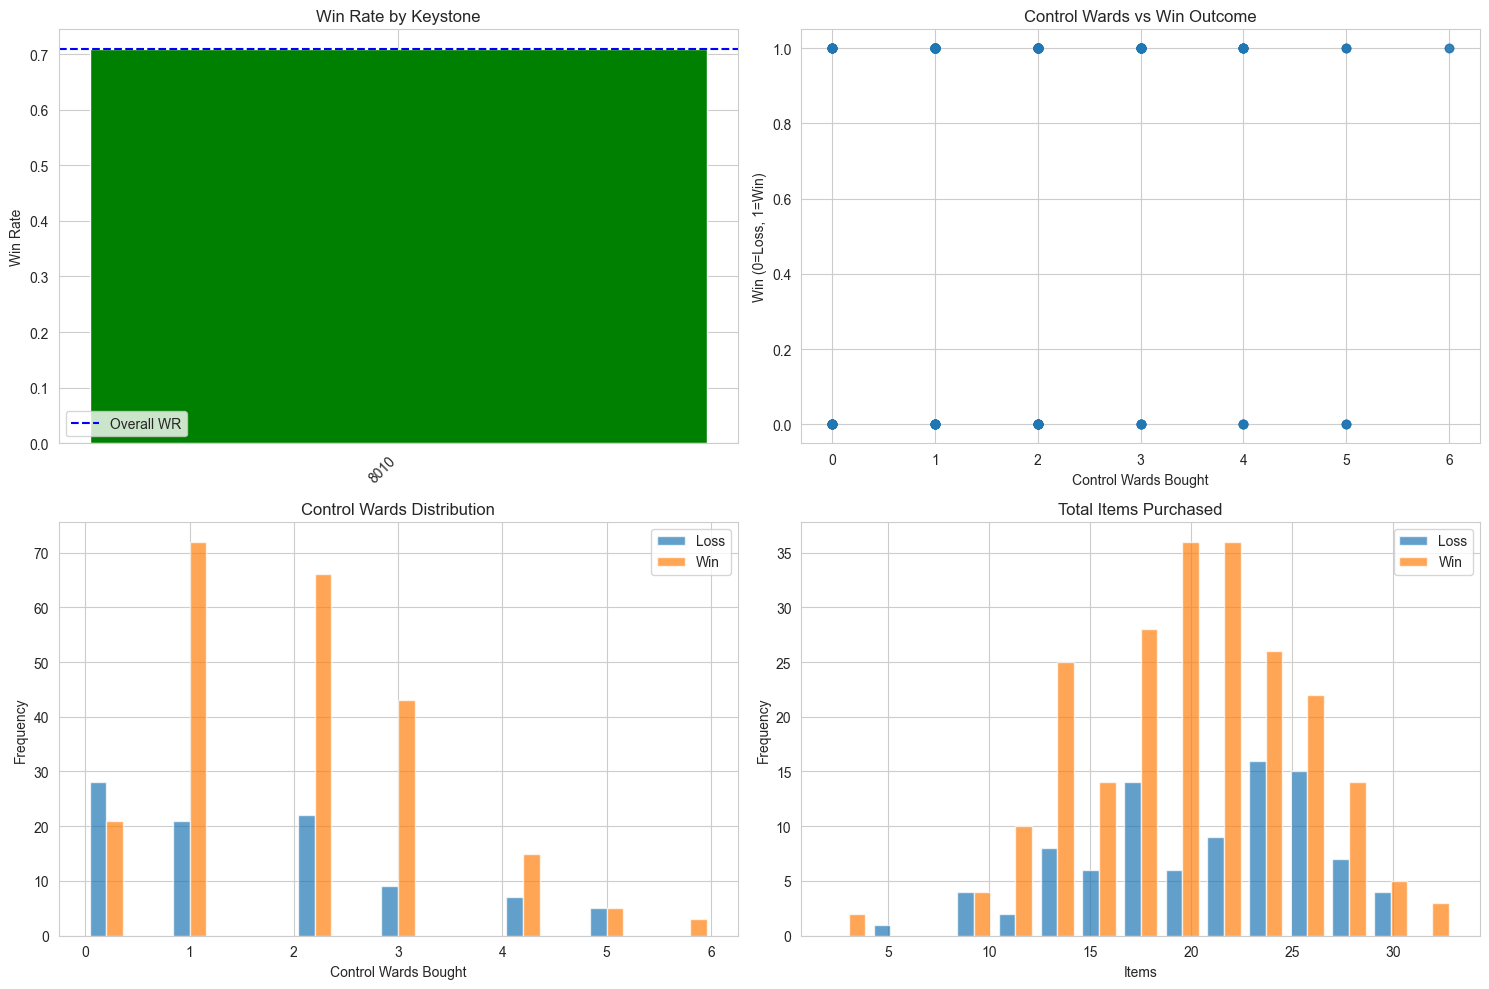


✓ Build & runes analysis complete


In [248]:
# ============================================================================
# 5. BUILD & RUNES ANALYSIS
# ============================================================================

print(f"\n{'='*80}")
print("5. BUILD & RUNES ANALYSIS")
print(f"{'='*80}")

# Keystone analysis
keystone_stats = matches.groupby('keystone').agg({
    'win': ['mean', 'count']
}).round(3)
keystone_stats.columns = ['Win Rate', 'Games']
keystone_stats = keystone_stats.sort_values('Games', ascending=False)

print(f"\n🔑 Keystone Usage:")
for keystone, row in keystone_stats.head(5).iterrows():
    print(f"  {keystone}: {row['Win Rate']:.1%} WR ({int(row['Games'])} games)")

# Primary tree
primary_tree_stats = matches.groupby('primary_tree').agg({
    'win': ['mean', 'count']
}).round(3)
primary_tree_stats.columns = ['Win Rate', 'Games']

print(f"\n🌳 Primary Rune Tree:")
for tree, row in primary_tree_stats.iterrows():
    print(f"  {tree}: {row['Win Rate']:.1%} WR ({int(row['Games'])} games)")

# Control wards
cw_stats = matches['control_wards_bought'].describe()
print(f"\n👁️  Control Wards Purchased:")
print(f"  Mean: {cw_stats['mean']:.2f}")
print(f"  Median: {cw_stats['50%']:.0f}")
print(f"  Wins: {matches[matches['win']==True]['control_wards_bought'].mean():.2f}")
print(f"  Losses: {matches[matches['win']==False]['control_wards_bought'].mean():.2f}")

# Summoner spells
summoner_combos = matches.groupby(['summoner_1', 'summoner_2']).size().sort_values(ascending=False)
print(f"\n✨ Most Common Summoner Spell Combos:")
for combo, count in summoner_combos.head(3).items():
    print(f"  {combo}: {count} games")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Keystone win rates
top_keystones = keystone_stats[keystone_stats['Games'] >= 10]
if len(top_keystones) > 0:
    axes[0, 0].bar(range(len(top_keystones)), top_keystones['Win Rate'], 
                   color=['green' if x > 0.5 else 'red' for x in top_keystones['Win Rate']])
    axes[0, 0].set_xticks(range(len(top_keystones)))
    axes[0, 0].set_xticklabels(top_keystones.index, rotation=45, ha='right')
    axes[0, 0].axhline(y=overall_wr, color='blue', linestyle='--', label='Overall WR')
    axes[0, 0].set_title('Win Rate by Keystone')
    axes[0, 0].set_ylabel('Win Rate')
    axes[0, 0].legend()

# Control wards vs win
axes[0, 1].scatter(matches['control_wards_bought'], matches['win'], alpha=0.5)
axes[0, 1].set_title('Control Wards vs Win Outcome')
axes[0, 1].set_xlabel('Control Wards Bought')
axes[0, 1].set_ylabel('Win (0=Loss, 1=Win)')

# Control wards distribution
axes[1, 0].hist([matches[matches['win']==False]['control_wards_bought'], 
                 matches[matches['win']==True]['control_wards_bought']], 
                label=['Loss', 'Win'], bins=15, alpha=0.7)
axes[1, 0].set_title('Control Wards Distribution')
axes[1, 0].set_xlabel('Control Wards Bought')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# Items purchased
axes[1, 1].hist([matches[matches['win']==False]['total_items_purchased'], 
                 matches[matches['win']==True]['total_items_purchased']], 
                label=['Loss', 'Win'], bins=15, alpha=0.7)
axes[1, 1].set_title('Total Items Purchased')
axes[1, 1].set_xlabel('Items')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\n✓ Build & runes analysis complete")



6. VISION & POSITIONING ANALYSIS

👁️  Vision Statistics:
       wards_placed  wards_destroyed  control_wards_placed  vision_score
count        317.00           317.00                317.00        317.00
mean           3.94             5.56                  1.60         23.91
std            1.67             3.31                  1.26          9.60
min            1.00             0.00                  0.00          0.00
25%            3.00             3.00                  1.00         16.00
50%            4.00             5.00                  1.00         23.00
75%            5.00             8.00                  2.00         31.00
max           11.00            19.00                  6.00         50.00

📊 Vision by Outcome:
       wards_placed  wards_destroyed  vision_score
win                                               
False          3.85             5.62         23.61
True           3.98             5.54         24.04

🗺️  Positioning Statistics:
       time_top_side_pct  time

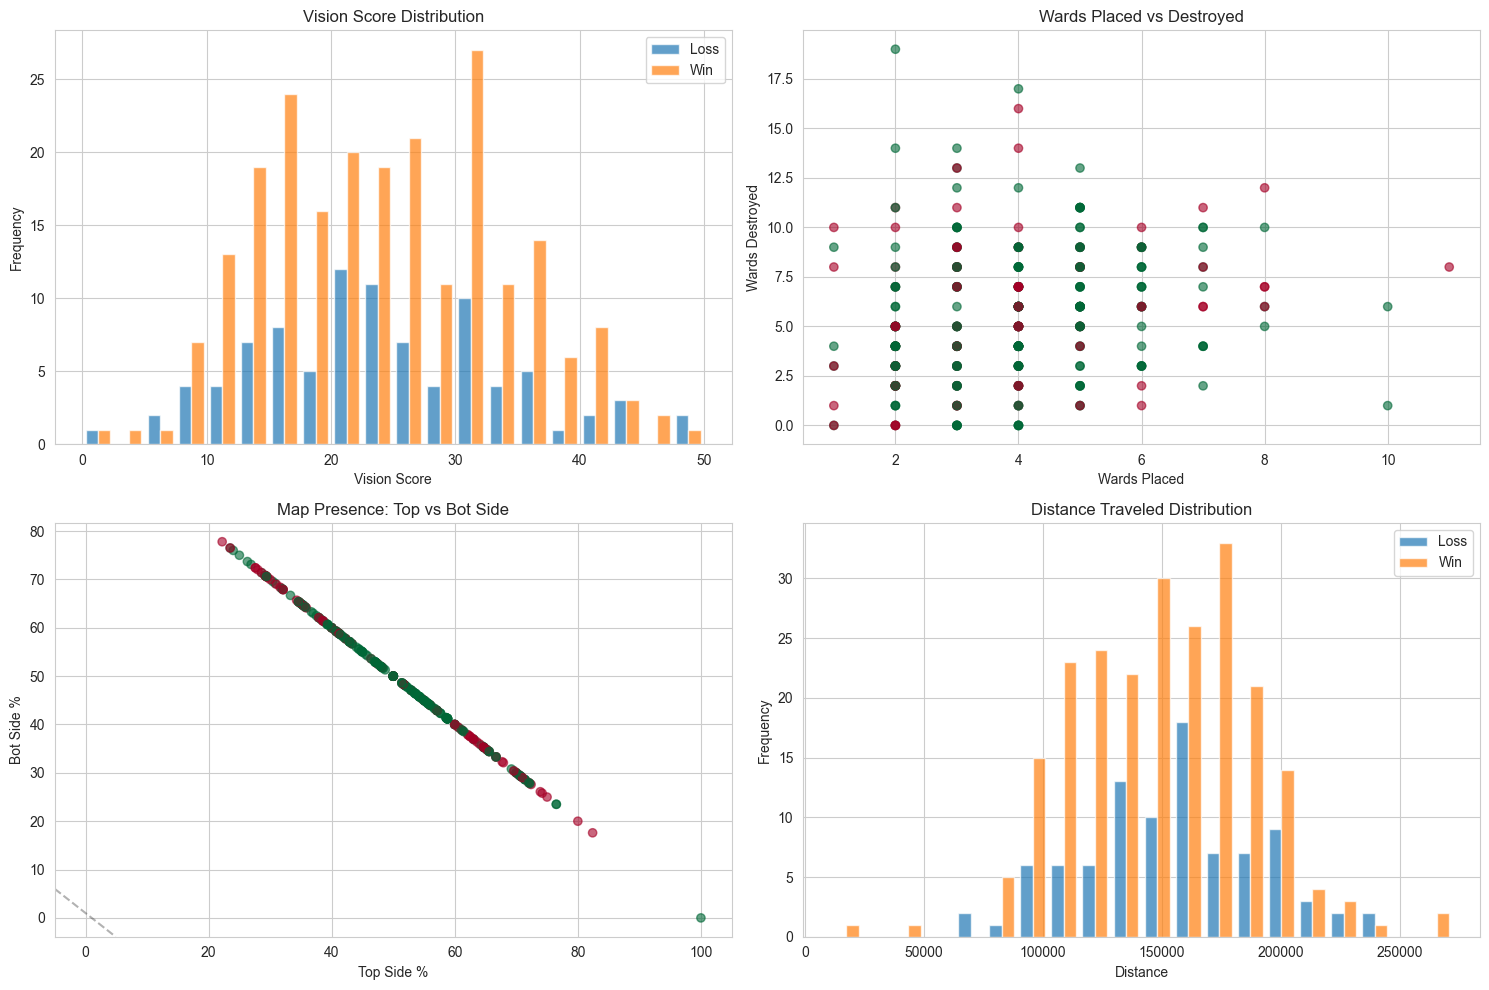


✓ Vision & positioning analysis complete


In [249]:
# ============================================================================
# 6. VISION & POSITIONING ANALYSIS
# ============================================================================

print(f"\n{'='*80}")
print("6. VISION & POSITIONING ANALYSIS")
print(f"{'='*80}")

# Vision metrics
vision_stats = matches[['wards_placed', 'wards_destroyed', 'control_wards_placed', 'vision_score']].describe()
print(f"\n👁️  Vision Statistics:")
print(vision_stats.round(2))

# Vision by outcome
vision_by_outcome = matches.groupby('win')[['wards_placed', 'wards_destroyed', 'vision_score']].mean()
print(f"\n📊 Vision by Outcome:")
print(vision_by_outcome.round(2))

# Positioning metrics
pos_stats = matches[['time_top_side_pct', 'time_bot_side_pct', 'distance_traveled']].describe()
print(f"\n🗺️  Positioning Statistics:")
print(pos_stats.round(2))

# Map presence by outcome
pos_by_outcome = matches.groupby('win')[['time_top_side_pct', 'time_bot_side_pct']].mean()
print(f"\n📍 Map Presence by Outcome:")
print(pos_by_outcome.round(3))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Vision score distribution
axes[0, 0].hist([matches[matches['win']==False]['vision_score'], 
                 matches[matches['win']==True]['vision_score']], 
                label=['Loss', 'Win'], bins=20, alpha=0.7)
axes[0, 0].set_title('Vision Score Distribution')
axes[0, 0].set_xlabel('Vision Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# Wards placed vs destroyed
axes[0, 1].scatter(matches['wards_placed'], matches['wards_destroyed'], 
                   c=matches['win'], cmap='RdYlGn', alpha=0.6)
axes[0, 1].set_title('Wards Placed vs Destroyed')
axes[0, 1].set_xlabel('Wards Placed')
axes[0, 1].set_ylabel('Wards Destroyed')

# Top vs Bot side preference
axes[1, 0].scatter(matches['time_top_side_pct'], matches['time_bot_side_pct'], 
                   c=matches['win'], cmap='RdYlGn', alpha=0.6)
axes[1, 0].set_title('Map Presence: Top vs Bot Side')
axes[1, 0].set_xlabel('Top Side %')
axes[1, 0].set_ylabel('Bot Side %')
axes[1, 0].axline((0, 1), slope=-1, color='black', linestyle='--', alpha=0.3)

# Distance traveled
axes[1, 1].hist([matches[matches['win']==False]['distance_traveled'], 
                 matches[matches['win']==True]['distance_traveled']], 
                label=['Loss', 'Win'], bins=20, alpha=0.7)
axes[1, 1].set_title('Distance Traveled Distribution')
axes[1, 1].set_xlabel('Distance')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\n✓ Vision & positioning analysis complete")



7. TEMPORAL PROGRESSION ANALYSIS

📊 Frame Data Loaded: 8,015 frames across 315 matches

💰 Gold Progression:
  10 min - Wins: 4367 | Losses: 3775
  15 min - Wins: 7354 | Losses: 6072
  20 min - Wins: 10540 | Losses: 8738

⚖️  Gold Differential vs Enemy Jungler:
  10 min - Wins: 547 | Losses: -255
  15 min - Wins: 1307 | Losses: -470


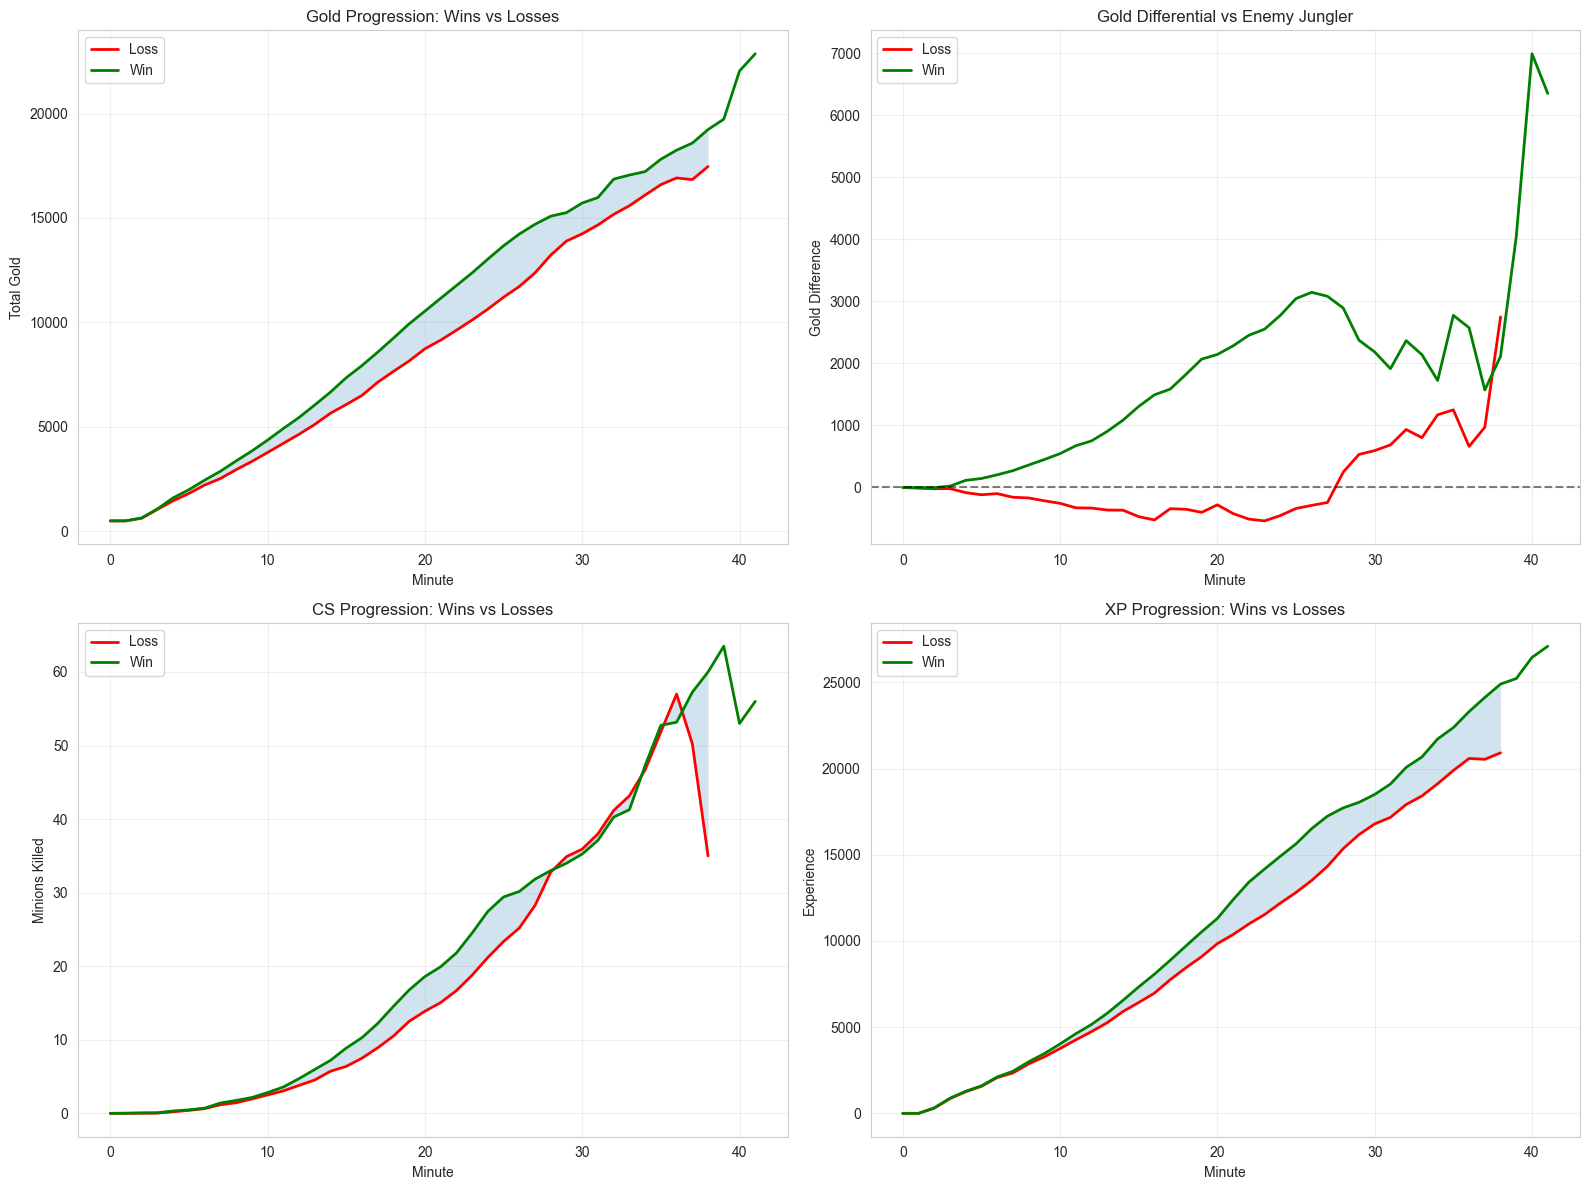


✓ Temporal progression analysis complete


In [250]:
# ============================================================================
# 7. TEMPORAL PROGRESSION ANALYSIS (Frame Data)
# ============================================================================

print(f"\n{'='*80}")
print("7. TEMPORAL PROGRESSION ANALYSIS")
print(f"{'='*80}")

# Filter for NattyNatt's frames only
natty_frames = frames[frames['is_nattynatt'] == True].copy()

# Merge with match outcomes
natty_frames = natty_frames.merge(matches[['match_id', 'win']], on='match_id', how='left')

print(f"\n📊 Frame Data Loaded: {len(natty_frames):,} frames across {natty_frames['match_id'].nunique()} matches")

# Gold curves by outcome
gold_curve = natty_frames.groupby(['minute', 'win'])['total_gold'].mean().unstack()

# XP curves by outcome
xp_curve = natty_frames.groupby(['minute', 'win'])['xp'].mean().unstack()

# CS curves by outcome
cs_curve = natty_frames.groupby(['minute', 'win'])['minions_killed'].mean().unstack()

# Damage curves by outcome
damage_curve = natty_frames.groupby(['minute', 'win'])['damage_dealt'].mean().unstack()

print(f"\n💰 Gold Progression:")
print(f"  10 min - Wins: {gold_curve.loc[10, True]:.0f} | Losses: {gold_curve.loc[10, False]:.0f}")
print(f"  15 min - Wins: {gold_curve.loc[15, True]:.0f} | Losses: {gold_curve.loc[15, False]:.0f}")
print(f"  20 min - Wins: {gold_curve.loc[20, True]:.0f} | Losses: {gold_curve.loc[20, False]:.0f}")

# Compare with enemy jungler
enemy_frames = frames[frames['role'] == 'JUNGLE'].copy()
enemy_frames = enemy_frames[enemy_frames['is_nattynatt'] == False]
enemy_frames = enemy_frames.merge(matches[['match_id', 'win']], on='match_id', how='left')

# Gold differential
gold_diff_curve = natty_frames.groupby(['minute', 'win'])['total_gold'].mean() - enemy_frames.groupby(['minute', 'win'])['total_gold'].mean()
gold_diff_curve = gold_diff_curve.unstack()

print(f"\n⚖️  Gold Differential vs Enemy Jungler:")
print(f"  10 min - Wins: {gold_diff_curve.loc[10, True]:.0f} | Losses: {gold_diff_curve.loc[10, False]:.0f}")
print(f"  15 min - Wins: {gold_diff_curve.loc[15, True]:.0f} | Losses: {gold_diff_curve.loc[15, False]:.0f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gold curves
gold_curve.plot(ax=axes[0, 0], linewidth=2, color=['red', 'green'])
axes[0, 0].fill_between(gold_curve.index, gold_curve[False], gold_curve[True], alpha=0.2)
axes[0, 0].set_title('Gold Progression: Wins vs Losses')
axes[0, 0].set_xlabel('Minute')
axes[0, 0].set_ylabel('Total Gold')
axes[0, 0].legend(['Loss', 'Win'])
axes[0, 0].grid(True, alpha=0.3)

# Gold differential vs enemy jungler
gold_diff_curve.plot(ax=axes[0, 1], linewidth=2, color=['red', 'green'])
axes[0, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0, 1].set_title('Gold Differential vs Enemy Jungler')
axes[0, 1].set_xlabel('Minute')
axes[0, 1].set_ylabel('Gold Difference')
axes[0, 1].legend(['Loss', 'Win'])
axes[0, 1].grid(True, alpha=0.3)

# CS curves
cs_curve.plot(ax=axes[1, 0], linewidth=2, color=['red', 'green'])
axes[1, 0].fill_between(cs_curve.index, cs_curve[False], cs_curve[True], alpha=0.2)
axes[1, 0].set_title('CS Progression: Wins vs Losses')
axes[1, 0].set_xlabel('Minute')
axes[1, 0].set_ylabel('Minions Killed')
axes[1, 0].legend(['Loss', 'Win'])
axes[1, 0].grid(True, alpha=0.3)

# XP curves
xp_curve.plot(ax=axes[1, 1], linewidth=2, color=['red', 'green'])
axes[1, 1].fill_between(xp_curve.index, xp_curve[False], xp_curve[True], alpha=0.2)
axes[1, 1].set_title('XP Progression: Wins vs Losses')
axes[1, 1].set_xlabel('Minute')
axes[1, 1].set_ylabel('Experience')
axes[1, 1].legend(['Loss', 'Win'])
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Temporal progression analysis complete")



8. COMBAT & TEAM COMPOSITION ANALYSIS

⚔️  Kill Participation:
  Mean: 5928.3%
  Median: 5910.0%
  Wins: 5912.8%
  Losses: 5966.3%

🎯 Solo Kills:
  Mean: 2.60
  Total: 824

🩸 First Blood Rate: 11.0%

👥 Most Frequent Teammates:
  TOP: Ambessa (45 games, 77.8% WR)
  MID: Orianna (36 games, 66.7% WR)
  ADC: Kaisa (47 games, 70.2% WR)
  SUPPORT: Alistar (32 games, 71.9% WR)

💀 Most Faced Enemy Champions:
  TOP: Ambessa (36 games, 61.1% WR)
  MID: Orianna (27 games, 77.8% WR)
  ADC: Kaisa (54 games, 68.5% WR)
  SUPPORT: Alistar (32 games, 53.1% WR)


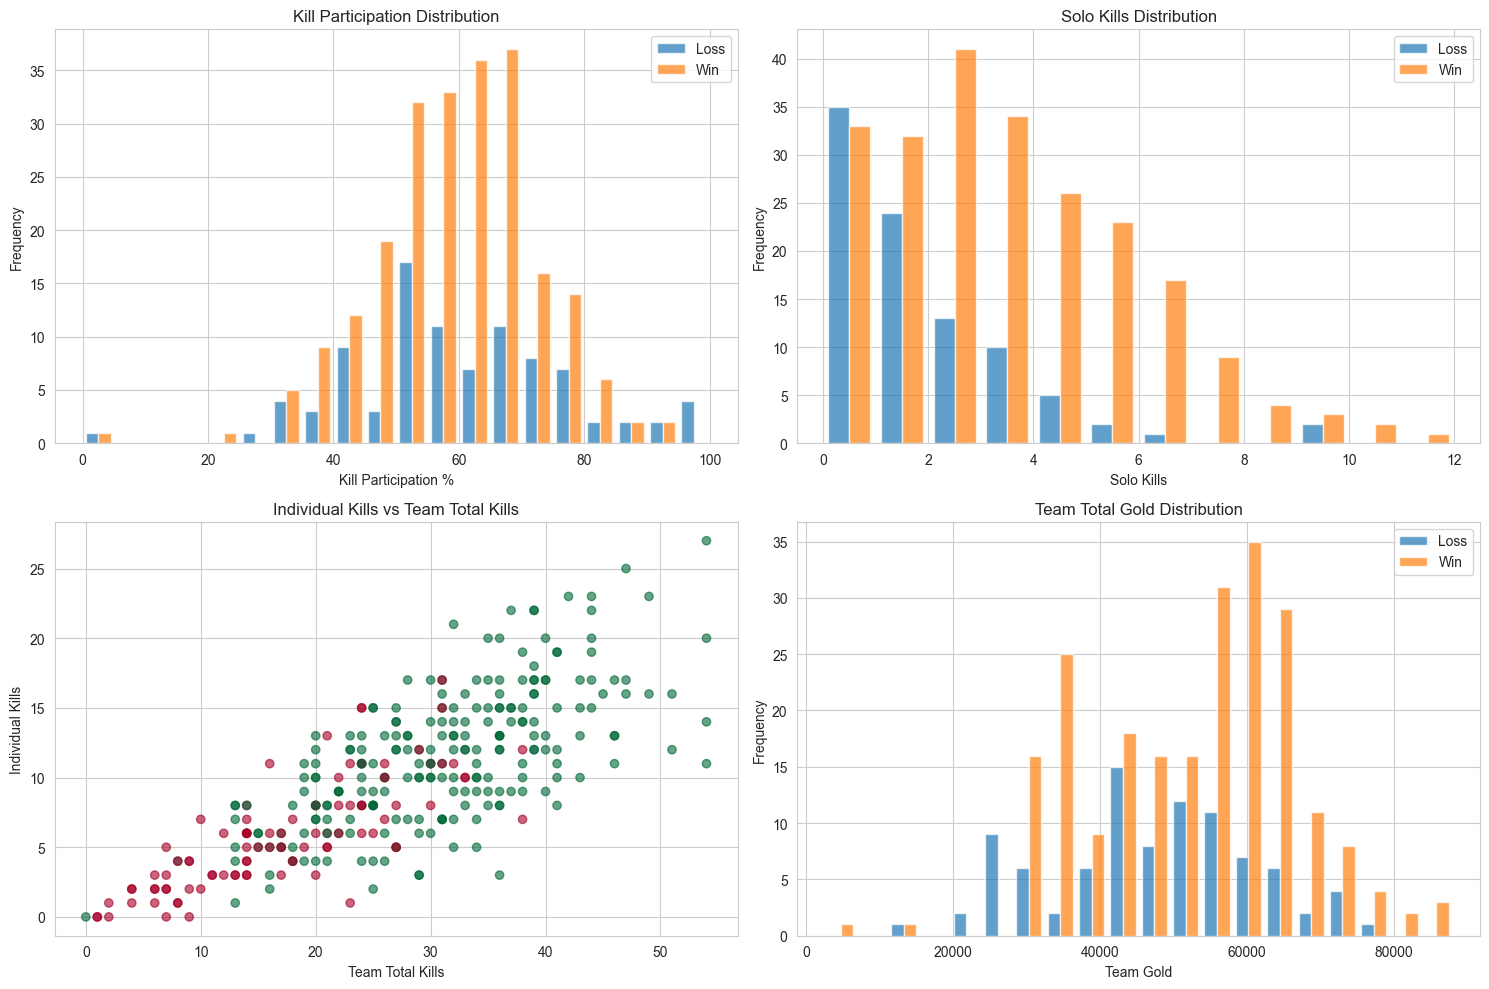


✓ Combat & team composition analysis complete


In [251]:
# ============================================================================
# 8. COMBAT & TEAM COMPOSITION ANALYSIS
# ============================================================================

print(f"\n{'='*80}")
print("8. COMBAT & TEAM COMPOSITION ANALYSIS")
print(f"{'='*80}")

# Kill participation
kp_stats = matches['kill_participation_pct'].describe()
print(f"\n⚔️  Kill Participation:")
print(f"  Mean: {kp_stats['mean']:.1%}")
print(f"  Median: {kp_stats['50%']:.1%}")
print(f"  Wins: {matches[matches['win']==True]['kill_participation_pct'].mean():.1%}")
print(f"  Losses: {matches[matches['win']==False]['kill_participation_pct'].mean():.1%}")

# Solo kills
solo_kills = matches['solo_kills'].describe()
print(f"\n🎯 Solo Kills:")
print(f"  Mean: {solo_kills['mean']:.2f}")
print(f"  Total: {int(matches['solo_kills'].sum())}")

# First blood
fb_rate = matches['first_blood'].mean()
print(f"\n🩸 First Blood Rate: {fb_rate:.1%}")

# Team composition - best allies
ally_cols = ['ally_top', 'ally_mid', 'ally_bot', 'ally_support']
print(f"\n👥 Most Frequent Teammates:")
for role in ally_cols:
    top_ally = matches[role].value_counts().head(1)
    if len(top_ally) > 0:
        champ = top_ally.index[0]
        count = top_ally.values[0]
        wr = matches[matches[role] == champ]['win'].mean()
        role_name = role.replace('ally_', '').upper()
        if role_name == 'BOT':
            role_name = 'ADC'
        print(f"  {role_name}: {champ} ({count} games, {wr:.1%} WR)")

# Enemy composition - hardest enemies
enemy_cols = ['enemy_top', 'enemy_mid', 'enemy_bot', 'enemy_support']
print(f"\n💀 Most Faced Enemy Champions:")
for role in enemy_cols:
    top_enemy = matches[role].value_counts().head(1)
    if len(top_enemy) > 0:
        champ = top_enemy.index[0]
        count = top_enemy.values[0]
        wr = matches[matches[role] == champ]['win'].mean()
        role_name = role.replace('enemy_', '').upper()
        if role_name == 'BOT':
            role_name = 'ADC'
        print(f"  {role_name}: {champ} ({count} games, {wr:.1%} WR)")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Kill participation distribution
axes[0, 0].hist([matches[matches['win']==False]['kill_participation_pct'], 
                 matches[matches['win']==True]['kill_participation_pct']], 
                label=['Loss', 'Win'], bins=20, alpha=0.7)
axes[0, 0].set_title('Kill Participation Distribution')
axes[0, 0].set_xlabel('Kill Participation %')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# Solo kills vs outcome
axes[0, 1].hist([matches[matches['win']==False]['solo_kills'], 
                 matches[matches['win']==True]['solo_kills']], 
                label=['Loss', 'Win'], bins=range(0, int(matches['solo_kills'].max())+2), alpha=0.7)
axes[0, 1].set_title('Solo Kills Distribution')
axes[0, 1].set_xlabel('Solo Kills')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# Team total kills
axes[1, 0].scatter(matches['team_total_kills'], matches['kills'], 
                   c=matches['win'], cmap='RdYlGn', alpha=0.6)
axes[1, 0].set_title('Individual Kills vs Team Total Kills')
axes[1, 0].set_xlabel('Team Total Kills')
axes[1, 0].set_ylabel('Individual Kills')

# Team total gold
axes[1, 1].hist([matches[matches['win']==False]['team_total_gold'], 
                 matches[matches['win']==True]['team_total_gold']], 
                label=['Loss', 'Win'], bins=20, alpha=0.7)
axes[1, 1].set_title('Team Total Gold Distribution')
axes[1, 1].set_xlabel('Team Gold')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\n✓ Combat & team composition analysis complete")



9. EVENT-BASED ANALYSIS

📊 Event Data: 28,673 events across 315 matches

🐺 Jungle Camps Cleared: 0 total
   Average per game: 0.0

⚔️  Champion Kills: 3,097 total

🛒 Item Purchases: 6,347 total
   Average per game: 20.1

👁️  Wards Placed: 1,241 total
   Average per game: 3.9


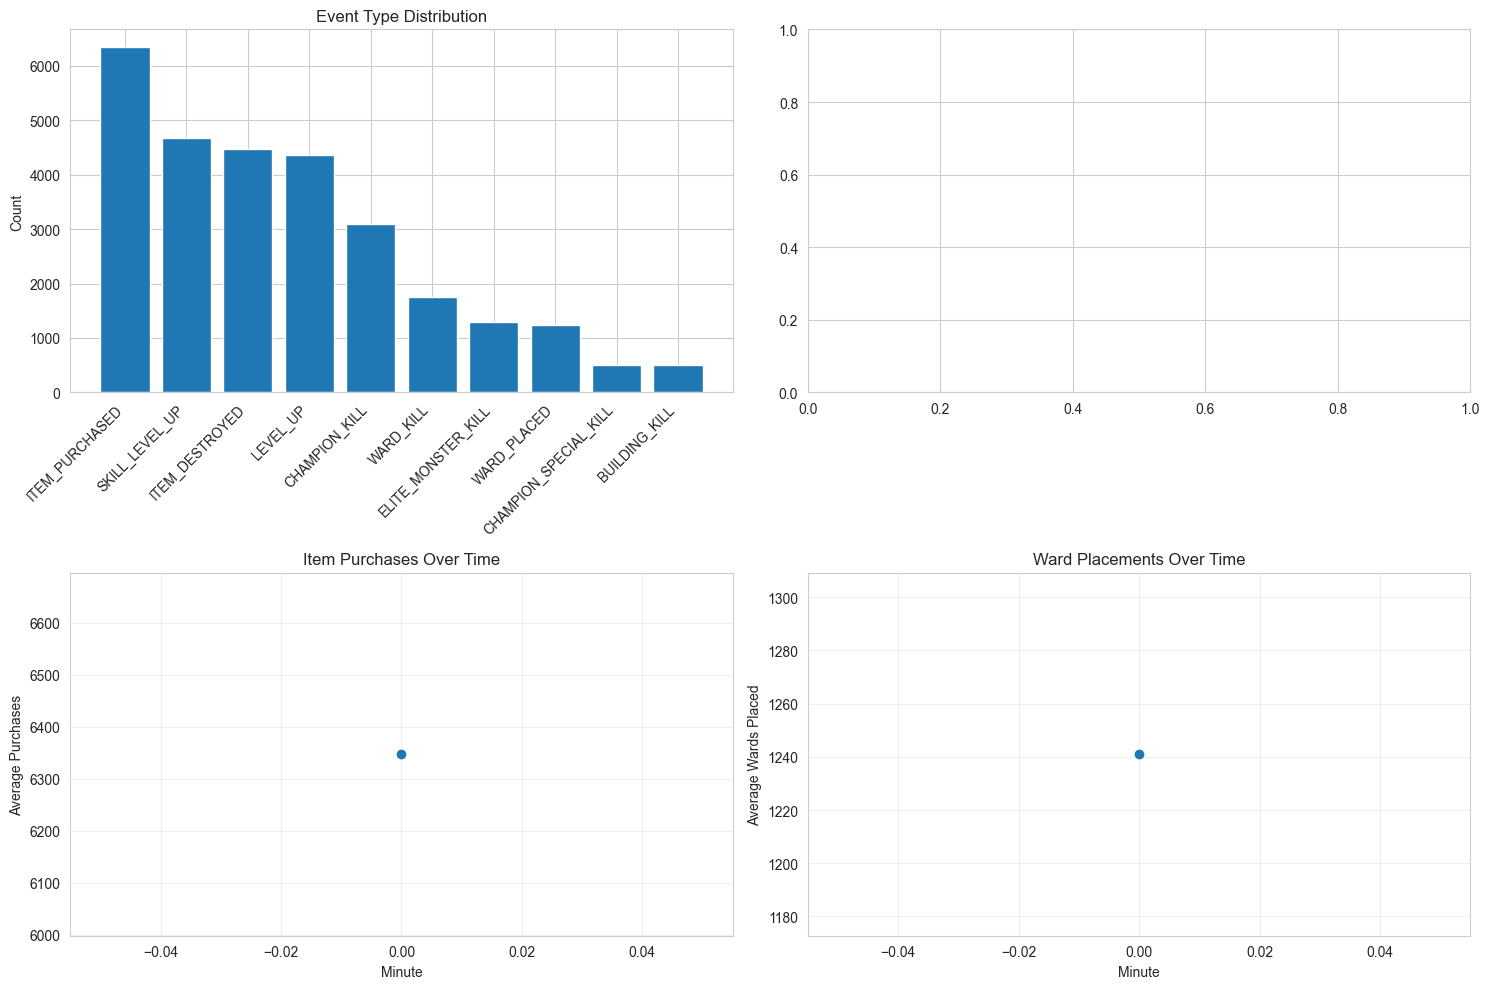


✓ Event-based analysis complete


In [252]:
# ============================================================================
# 9. EVENT-BASED ANALYSIS
# ============================================================================

print(f"\n{'='*80}")
print("9. EVENT-BASED ANALYSIS")
print(f"{'='*80}")

# Filter for target player events
natty_events = events[events['is_nattynatt'] == True].copy()

print(f"\n📊 Event Data: {len(natty_events):,} events across {natty_events['match_id'].nunique()} matches")

# Monster kills (jungle camps)
monster_events = natty_events[natty_events['event_type'] == 'MONSTER_KILL'].copy()
print(f"\n🐺 Jungle Camps Cleared: {len(monster_events):,} total")

# Average camps per game
camps_per_game = len(monster_events) / natty_events['match_id'].nunique()
print(f"   Average per game: {camps_per_game:.1f}")

# Champion kills
kill_events = natty_events[natty_events['event_type'] == 'CHAMPION_KILL'].copy()
print(f"\n⚔️  Champion Kills: {len(kill_events):,} total")

# Item purchases
item_events = natty_events[natty_events['event_type'] == 'ITEM_PURCHASED'].copy()
print(f"\n🛒 Item Purchases: {len(item_events):,} total")
print(f"   Average per game: {len(item_events) / natty_events['match_id'].nunique():.1f}")

# Ward placements
ward_events = natty_events[natty_events['event_type'] == 'WARD_PLACED'].copy()
print(f"\n👁️  Wards Placed: {len(ward_events):,} total")
print(f"   Average per game: {len(ward_events) / natty_events['match_id'].nunique():.1f}")

# Timing analysis
if len(monster_events) > 0:
    monster_events['minute'] = monster_events['timestamp'] / 60000
    print(f"\n⏱️  First Camp Timing:")
    first_camps = monster_events.groupby('match_id')['minute'].min()
    print(f"   Mean: {first_camps.mean():.2f} min")
    print(f"   Median: {first_camps.median():.2f} min")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Event type distribution
event_counts = natty_events['event_type'].value_counts().head(10)
axes[0, 0].bar(range(len(event_counts)), event_counts.values)
axes[0, 0].set_xticks(range(len(event_counts)))
axes[0, 0].set_xticklabels(event_counts.index, rotation=45, ha='right')
axes[0, 0].set_title('Event Type Distribution')
axes[0, 0].set_ylabel('Count')

# Monster kills over time
if len(monster_events) > 0:
    monster_events['minute_bin'] = (monster_events['timestamp'] / 60000).astype(int)
    monster_timeline = monster_events.groupby('minute_bin').size()
    axes[0, 1].plot(monster_timeline.index, monster_timeline.values, marker='o')
    axes[0, 1].set_title('Jungle Camps Cleared Over Time')
    axes[0, 1].set_xlabel('Minute')
    axes[0, 1].set_ylabel('Average Camps Cleared')
    axes[0, 1].grid(True, alpha=0.3)

# Item purchases over time
if len(item_events) > 0:
    item_events['minute_bin'] = (item_events['timestamp'] / 60000).astype(int)
    item_timeline = item_events.groupby('minute_bin').size()
    axes[1, 0].plot(item_timeline.index, item_timeline.values, marker='o')
    axes[1, 0].set_title('Item Purchases Over Time')
    axes[1, 0].set_xlabel('Minute')
    axes[1, 0].set_ylabel('Average Purchases')
    axes[1, 0].grid(True, alpha=0.3)

# Ward placements over time
if len(ward_events) > 0:
    ward_events['minute_bin'] = (ward_events['timestamp'] / 60000).astype(int)
    ward_timeline = ward_events.groupby('minute_bin').size()
    axes[1, 1].plot(ward_timeline.index, ward_timeline.values, marker='o')
    axes[1, 1].set_title('Ward Placements Over Time')
    axes[1, 1].set_xlabel('Minute')
    axes[1, 1].set_ylabel('Average Wards Placed')
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Event-based analysis complete")



10. CORRELATION & MULTIVARIATE ANALYSIS

📊 Top 15 Features Correlated with Wins:
   1. team_total_kills              : +0.562
   2. level_at_20min                : +0.528
   3. xp_at_20min                   : +0.527
   4. kda                           : +0.524
   5. gold_at_15min                 : +0.501
   6. gold_at_20min                 : +0.493
   7. dragons_killed                : +0.490
   8. kills                         : +0.487
   9. xp_at_15min                   : +0.476
  10. cs_per_min                    : +0.466
  11. level_at_15min                : +0.437
  12. damage_dealt_at_20min         : +0.401
  13. gold_at_10min                 : +0.393
  14. turrets_killed                : +0.390
  15. damage_dealt_at_15min         : +0.388

📉 Bottom 10 Features (Negative Correlation):
   1. rune_3                        : +nan
   2. secondary_tree                : +nan
   3. stat_shard_1                  : +nan
   4. stat_shard_2                  : +nan
   5. stat_shard_3       

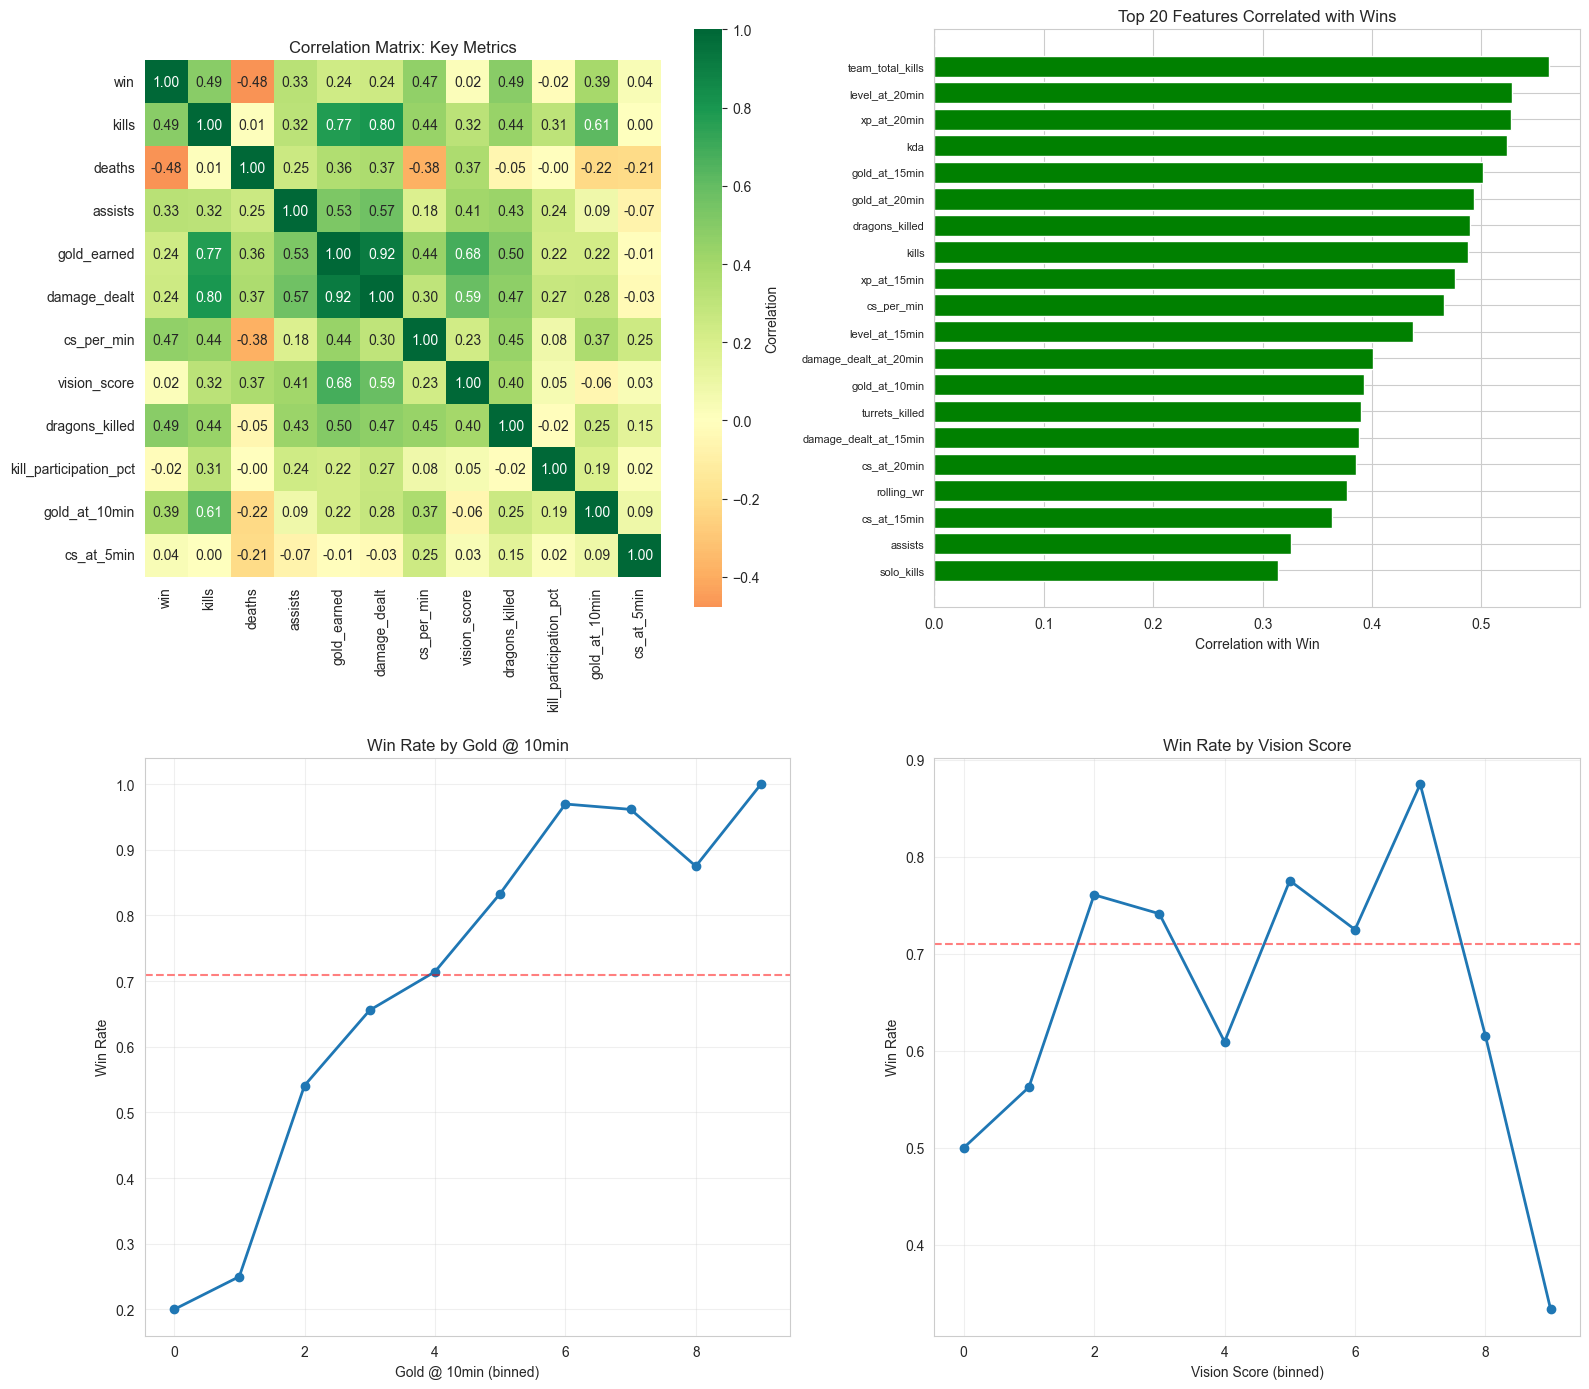


✓ Correlation analysis complete


In [253]:
# ============================================================================
# 10. CORRELATION & MULTIVARIATE ANALYSIS
# ============================================================================

print(f"\n{'='*80}")
print("10. CORRELATION & MULTIVARIATE ANALYSIS")
print(f"{'='*80}")

# Select numeric columns for correlation
numeric_cols = matches.select_dtypes(include=[np.number]).columns.tolist()

# Remove ID columns and redundant columns
exclude_cols = ['match_id', 'game_creation', 'participant_id', 'game_duration']
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

# Calculate correlation with win
correlations = matches[numeric_cols].corrwith(matches['win']).sort_values(ascending=False)

print(f"\n📊 Top 15 Features Correlated with Wins:")
for i, (feature, corr) in enumerate(correlations.head(15).items(), 1):
    print(f"  {i:2d}. {feature:30s}: {corr:+.3f}")

print(f"\n📉 Bottom 10 Features (Negative Correlation):")
for i, (feature, corr) in enumerate(correlations.tail(10).items(), 1):
    print(f"  {i:2d}. {feature:30s}: {corr:+.3f}")

# Key metrics correlation matrix
key_metrics = ['win', 'kills', 'deaths', 'assists', 'gold_earned', 'damage_dealt', 
               'cs_per_min', 'vision_score', 'dragons_killed', 'kill_participation_pct',
               'gold_at_10min', 'cs_at_5min']

# Filter to existing columns
key_metrics = [col for col in key_metrics if col in matches.columns]
corr_matrix = matches[key_metrics].corr()

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Correlation heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlGn', center=0, 
            square=True, ax=axes[0, 0], cbar_kws={'label': 'Correlation'})
axes[0, 0].set_title('Correlation Matrix: Key Metrics')

# Top correlations with win
top_corrs = correlations.head(20)
axes[0, 1].barh(range(len(top_corrs)), top_corrs.values, 
                color=['green' if x > 0 else 'red' for x in top_corrs.values])
axes[0, 1].set_yticks(range(len(top_corrs)))
axes[0, 1].set_yticklabels(top_corrs.index, fontsize=8)
axes[0, 1].set_xlabel('Correlation with Win')
axes[0, 1].set_title('Top 20 Features Correlated with Wins')
axes[0, 1].axvline(x=0, color='black', linestyle='--', alpha=0.5)
axes[0, 1].invert_yaxis()

# Gold at 10 min vs Win Rate
gold_10_bins = pd.cut(matches['gold_at_10min'], bins=10)
gold_10_wr = matches.groupby(gold_10_bins)['win'].mean()
axes[1, 0].plot(range(len(gold_10_wr)), gold_10_wr.values, marker='o', linewidth=2)
axes[1, 0].set_title('Win Rate by Gold @ 10min')
axes[1, 0].set_xlabel('Gold @ 10min (binned)')
axes[1, 0].set_ylabel('Win Rate')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(y=overall_wr, color='r', linestyle='--', alpha=0.5)

# Vision Score vs Win Rate
vision_bins = pd.cut(matches['vision_score'], bins=10)
vision_wr = matches.groupby(vision_bins)['win'].mean()
axes[1, 1].plot(range(len(vision_wr)), vision_wr.values, marker='o', linewidth=2)
axes[1, 1].set_title('Win Rate by Vision Score')
axes[1, 1].set_xlabel('Vision Score (binned)')
axes[1, 1].set_ylabel('Win Rate')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(y=overall_wr, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("\n✓ Correlation analysis complete")


In [254]:
# ============================================================================
# 11. STATISTICAL TESTS
# ============================================================================

print(f"\n{'='*80}")
print("11. STATISTICAL TESTS")
print(f"{'='*80}")

# T-tests: Wins vs Losses for key metrics
test_metrics = ['kills', 'deaths', 'assists', 'gold_earned', 'damage_dealt', 
                'cs_per_min', 'vision_score', 'gold_at_10min', 'kill_participation_pct']

print(f"\n📊 T-Tests: Wins vs Losses")
print(f"{'─'*70}")
print(f"{'Metric':<25} {'Win Mean':>12} {'Loss Mean':>12} {'p-value':>10}")
print(f"{'─'*70}")

for metric in test_metrics:
    if metric in matches.columns:
        wins = matches[matches['win']==True][metric].dropna()
        losses = matches[matches['win']==False][metric].dropna()
        
        t_stat, p_value = stats.ttest_ind(wins, losses)
        
        significance = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else ''
        print(f"{metric:<25} {wins.mean():>12.2f} {losses.mean():>12.2f} {p_value:>10.4f} {significance}")

print(f"\n* p < 0.05, ** p < 0.01, *** p < 0.001")

# Chi-square test: First blood vs Win
if 'first_blood' in matches.columns:
    contingency_table = pd.crosstab(matches['first_blood'], matches['win'])
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    
    print(f"\n🔬 Chi-Square Test: First Blood vs Win")
    print(f"  Chi-square statistic: {chi2:.4f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Result: {'Significant' if p_value < 0.05 else 'Not significant'}")

# ANOVA: Performance across different matchups (top 5 enemy junglers)
top_matchups = matches['enemy_jungle'].value_counts().head(5).index
matchup_data = [matches[matches['enemy_jungle']==champ]['gold_at_10min'].dropna() 
                for champ in top_matchups]

if len(matchup_data) >= 2:
    f_stat, p_value = stats.f_oneway(*matchup_data)
    
    print(f"\n📈 ANOVA: Gold@10min across Top 5 Matchups")
    print(f"  F-statistic: {f_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Result: {'Significant differences exist' if p_value < 0.05 else 'No significant differences'}")

# Logistic Regression: Predict win probability
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Select features for prediction
feature_cols = ['kills', 'deaths', 'assists', 'gold_at_10min', 'cs_at_5min', 
                'vision_score', 'dragons_killed']
feature_cols = [col for col in feature_cols if col in matches.columns]

# Prepare data
X = matches[feature_cols].fillna(matches[feature_cols].mean())
y = matches['win']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\n🤖 Logistic Regression: Win Probability Prediction")
print(f"  Features used: {', '.join(feature_cols)}")
print(f"  Accuracy: {accuracy:.3f}")
print(f"  ROC-AUC: {roc_auc:.3f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': model.coef_[0]
}).sort_values('coefficient', ascending=False)

print(f"\n  Feature Importance (coefficients):")
for _, row in feature_importance.iterrows():
    print(f"    {row['feature']:<20}: {row['coefficient']:+.4f}")

print("\n✓ Statistical tests complete")



11. STATISTICAL TESTS

📊 T-Tests: Wins vs Losses
──────────────────────────────────────────────────────────────────────
Metric                        Win Mean    Loss Mean    p-value
──────────────────────────────────────────────────────────────────────
kills                            11.47         5.79     0.0000 ***
deaths                            3.49         6.42     0.0000 ***
assists                           6.89         4.28     0.0000 ***
gold_earned                   13300.49     11216.66     0.0000 ***
damage_dealt                  23933.30     17611.41     0.0000 ***
cs_per_min                        8.38         7.26     0.0000 ***
vision_score                     24.04        23.61     0.7200 
gold_at_10min                  4360.30      3775.02     0.0000 ***
kill_participation_pct           59.13        59.66     0.7633 

* p < 0.05, ** p < 0.01, *** p < 0.001

🔬 Chi-Square Test: First Blood vs Win
  Chi-square statistic: 0.0675
  p-value: 0.7951
  Result: Not signif

In [255]:
# ============================================================================
# 12. EXPORT KEY INSIGHTS TO JSON (For Next.js Frontend)
# ============================================================================

print(f"\n{'='*80}")
print("12. EXPORTING KEY INSIGHTS TO JSON")
print(f"{'='*80}")

# Ensure we have clean scalar values
total_games_clean = len(matches)
wins_clean = int(matches['win'].sum())
losses_clean = total_games_clean - wins_clean
overall_wr_clean = matches['win'].mean()

# Build comprehensive insights dictionary
insights = {
    "metadata": {
        "generated_at": datetime.now().isoformat(),
        "total_games": total_games_clean,
        "date_range": {
            "start": matches['game_date'].min().isoformat(),
            "end": matches['game_date'].max().isoformat()
        }
    },
    
    "overall_performance": {
        "win_rate": float(overall_wr_clean),
        "wins": wins_clean,
        "losses": losses_clean,
        "confidence_interval": [float(ci_lower), float(ci_upper)],
        "recent_performance": {
            "last_10": float(matches.tail(10)['win'].mean()),
            "last_20": float(matches.tail(20)['win'].mean()),
            "last_50": float(matches.tail(50)['win'].mean())
        },
        "streaks": {
            "longest_win_streak": int(longest_win_streak),
            "longest_loss_streak": int(longest_loss_streak)
        }
    },
    
    "kda_stats": {
        "mean_kda": float(matches['kda'].mean()),
        "median_kda": float(matches['kda'].median()),
        "mean_kills": float(matches['kills'].mean()),
        "mean_deaths": float(matches['deaths'].mean()),
        "mean_assists": float(matches['assists'].mean()),
        "by_outcome": {
            "wins": {
                "kda": float(matches[matches['win']==True]['kda'].mean()),
                "kills": float(matches[matches['win']==True]['kills'].mean()),
                "deaths": float(matches[matches['win']==True]['deaths'].mean()),
                "assists": float(matches[matches['win']==True]['assists'].mean())
            },
            "losses": {
                "kda": float(matches[matches['win']==False]['kda'].mean()),
                "kills": float(matches[matches['win']==False]['kills'].mean()),
                "deaths": float(matches[matches['win']==False]['deaths'].mean()),
                "assists": float(matches[matches['win']==False]['assists'].mean())
            }
        }
    },
    
    "economy": {
        "avg_gold_earned": float(matches['gold_earned'].mean()),
        "avg_cs_per_min": float(matches['cs_per_min'].mean()),
        "avg_damage_dealt": float(matches['damage_dealt'].mean()),
        "damage_per_gold": float(matches['damage_per_gold'].mean()),
        "gold_progression": {
            "5min": float(matches['gold_at_5min'].mean()),
            "10min": float(matches['gold_at_10min'].mean()),
            "15min": float(matches['gold_at_15min'].mean()),
            "20min": float(matches['gold_at_20min'].mean())
        }
    },
    
    "matchups": {
        "best_matchups": [
            {
                "champion": str(idx),
                "win_rate": float(row['Win Rate']),
                "games": int(row['Games'])
            }
            for idx, row in best_matchups.iterrows()
        ],
        "worst_matchups": [
            {
                "champion": str(idx),
                "win_rate": float(row['Win Rate']),
                "games": int(row['Games'])
            }
            for idx, row in worst_matchups.iterrows()
        ]
    },
    
    "early_game": {
        "avg_cs_at_5min": float(matches['cs_at_5min'].mean()),
        "avg_gold_at_5min": float(matches['gold_at_5min'].mean()),
        "avg_first_gank_time": float(matches['first_gank_time'].mean() / 60) if 'first_gank_time' in matches.columns else None,
        "avg_ganks_by_5min": float(matches['ganks_by_5min'].mean())
    },
    
    "objectives": {
        "dragons": {
            "avg_per_game": float(matches['dragons_killed'].mean()),
            "win_rate_by_count": {
                int(drags): float(row['mean']) 
                for drags, row in dragon_wr.iterrows() if row['count'] >= 5
            }
        },
        "herald_take_rate": float(herald_rate),
        "baron_take_rate": float(baron_rate),
        "avg_turrets": {
            "wins": float(turret_stats[True]),
            "losses": float(turret_stats[False])
        },
        "first_turret_rate": float(first_turret_rate)
    },
    
    "vision": {
        "avg_wards_placed": float(matches['wards_placed'].mean()),
        "avg_wards_destroyed": float(matches['wards_destroyed'].mean()),
        "avg_vision_score": float(matches['vision_score'].mean()),
        "avg_control_wards": float(matches['control_wards_bought'].mean())
    },
    
    "combat": {
        "avg_kill_participation": float(matches['kill_participation_pct'].mean()),
        "avg_solo_kills": float(matches['solo_kills'].mean()),
        "first_blood_rate": float(fb_rate)
    },
    
    "top_correlations": {
        feature: float(corr) 
        for feature, corr in correlations.head(10).items()
    },
    
    "temporal_progression": {
        "gold_curve_wins": [float(x) for x in gold_curve[True].values],
        "gold_curve_losses": [float(x) for x in gold_curve[False].values],
        "minutes": [int(x) for x in gold_curve.index]
    }
}

# Save to JSON
output_path = 'data/analysis_insights.json'
with open(output_path, 'w') as f:
    json.dump(insights, f, indent=2)

print(f"\n✅ Insights exported to: {output_path}")
print(f"   File size: {len(json.dumps(insights)) / 1024:.1f} KB")
print(f"   Top-level keys: {list(insights.keys())}")

print("\n" + "="*80)
print("🎉 ANALYSIS COMPLETE!")
print("="*80)
print(f"\nSummary:")
print(f"  • Analyzed {total_games_clean} matches")
print(f"  • Overall win rate: {overall_wr_clean:.1%}")
print(f"  • {len(frames):,} frame records processed")
print(f"  • {len(events):,} events analyzed")
print(f"  • Insights exported to JSON for frontend")
print(f"\n✓ All analyses complete and ready for visualization!")
print("="*80)



12. EXPORTING KEY INSIGHTS TO JSON

✅ Insights exported to: data/analysis_insights.json
   File size: 4.6 KB
   Top-level keys: ['metadata', 'overall_performance', 'kda_stats', 'economy', 'matchups', 'early_game', 'objectives', 'vision', 'combat', 'top_correlations', 'temporal_progression']

🎉 ANALYSIS COMPLETE!

Summary:
  • Analyzed 317 matches
  • Overall win rate: 71.0%
  • 80,150 frame records processed
  • 309,101 events analyzed
  • Insights exported to JSON for frontend

✓ All analyses complete and ready for visualization!



POSITIONING HEATMAP ANALYSIS

📍 Position Data Points: 8,015
   X range: [275, 14539]
   Y range: [285, 14598]


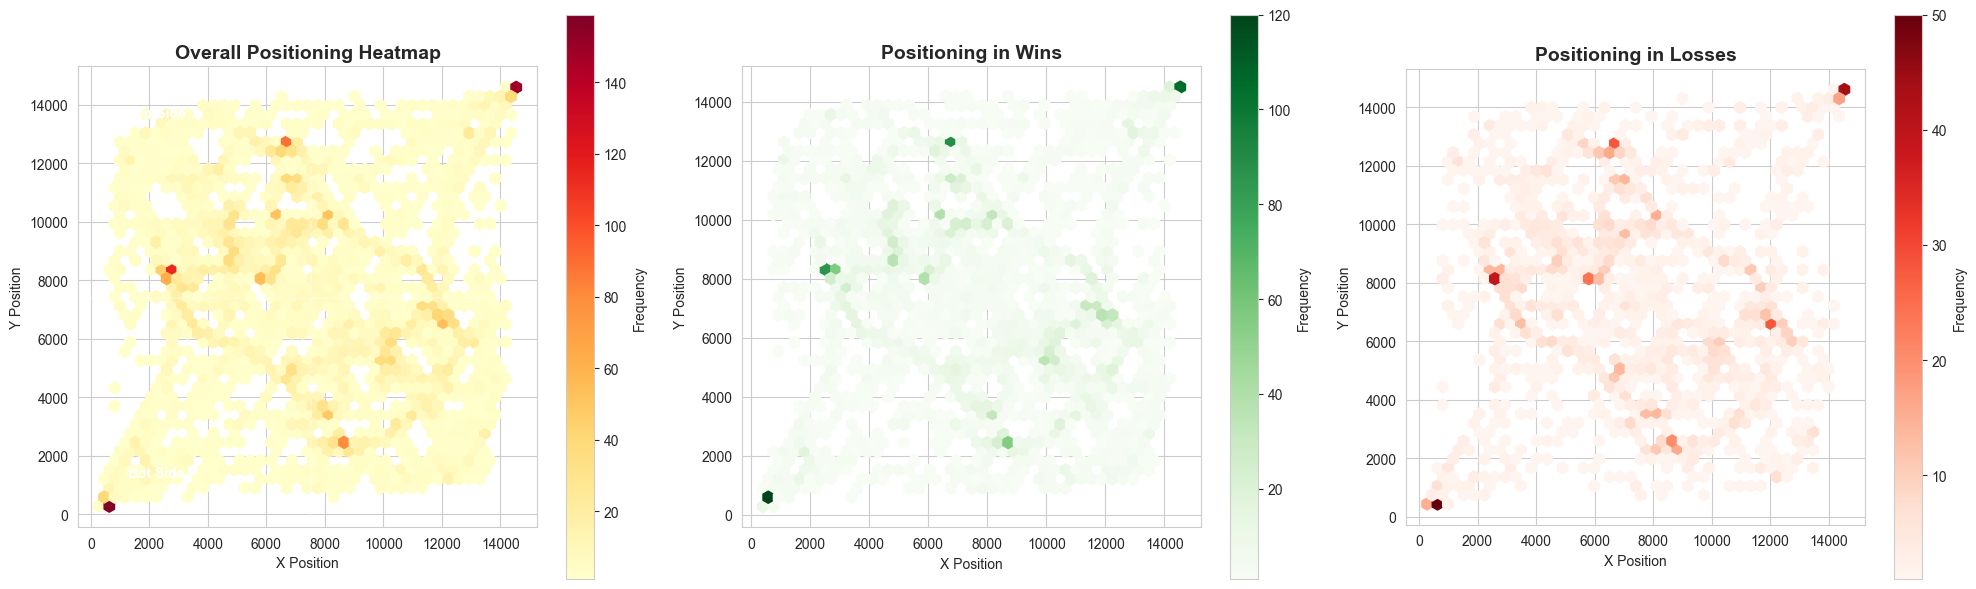

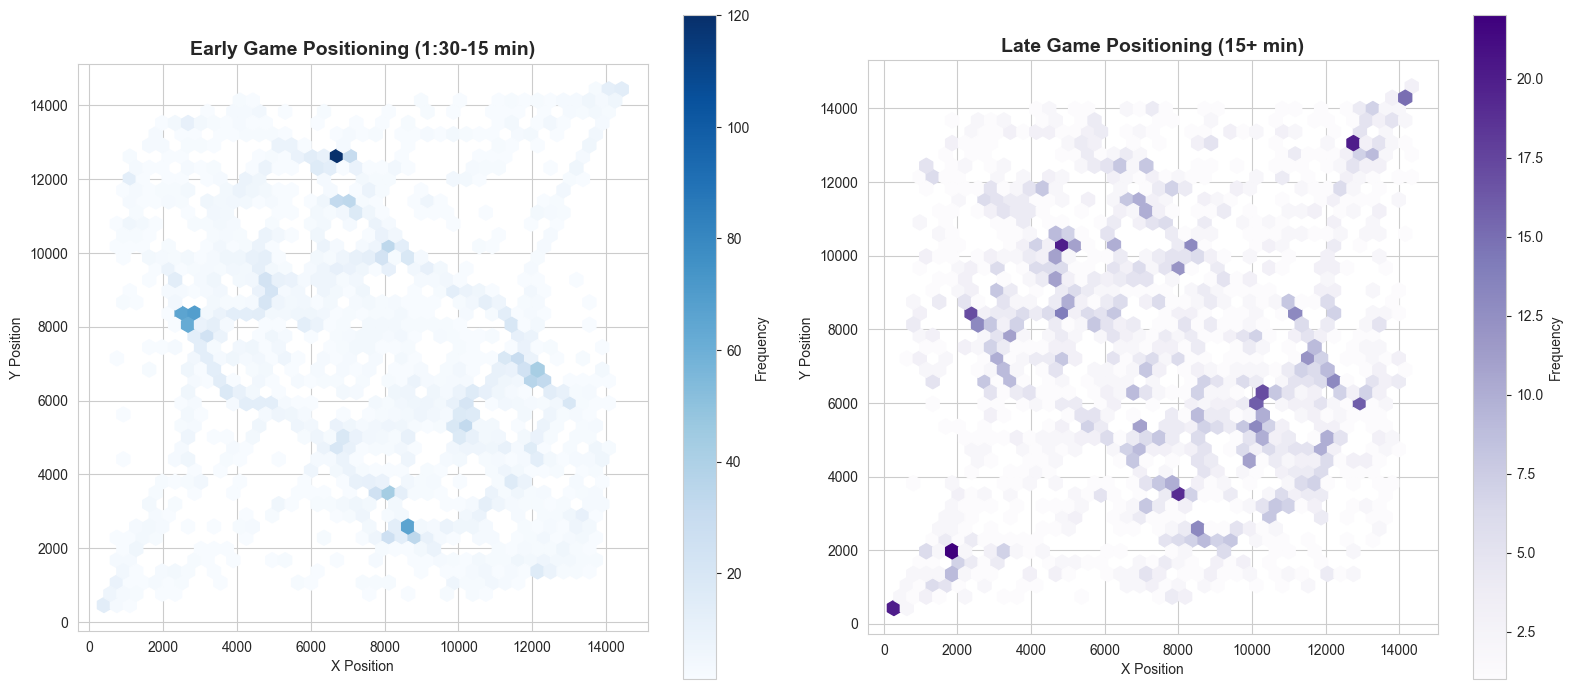


📊 Positioning Statistics (After 1:30):
────────────────────────────────────────────────────────────
Active Gameplay Avg: (7567, 7356)

Early Game (1:30-15 min):
  Avg: (7573, 7353)
  Frames: 4,382

Late Game (15+ min):
  Avg: (7558, 7361)
  Frames: 3,003

✓ Positioning heatmap analysis complete

💡 TIP: To overlay on official League map, download Summoner's Rift image
   and use plt.imshow() before creating the heatmap!


In [256]:
# ============================================================================
# BONUS: POSITIONING HEATMAP ON SUMMONER'S RIFT
# ============================================================================

print(f"\n{'='*80}")
print("POSITIONING HEATMAP ANALYSIS")
print(f"{'='*80}")

# Filter for NattyNatt's position data
position_data = natty_frames[['position_x', 'position_y']].dropna()

print(f"\n📍 Position Data Points: {len(position_data):,}")
print(f"   X range: [{position_data['position_x'].min():.0f}, {position_data['position_x'].max():.0f}]")
print(f"   Y range: [{position_data['position_y'].min():.0f}, {position_data['position_y'].max():.0f}]")

# Separate by outcome
wins_positions = natty_frames[natty_frames['win']==True][['position_x', 'position_y']].dropna()
losses_positions = natty_frames[natty_frames['win']==False][['position_x', 'position_y']].dropna()

# Create visualizations
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Summoner's Rift dimensions (approximate)
# The map is 14870 x 14870 units
# Blue side is bottom-left, Red side is top-right

# Overall heatmap
h1 = axes[0].hexbin(position_data['position_x'], position_data['position_y'], 
                     gridsize=40, cmap='YlOrRd', mincnt=1)
axes[0].set_title('Overall Positioning Heatmap', fontsize=14, fontweight='bold')
axes[0].set_xlabel('X Position')
axes[0].set_ylabel('Y Position')
axes[0].set_aspect('equal')
plt.colorbar(h1, ax=axes[0], label='Frequency')

# Add map quadrants
axes[0].axhline(y=position_data['position_y'].mean(), color='white', linestyle='--', alpha=0.3)
axes[0].axvline(x=position_data['position_x'].mean(), color='white', linestyle='--', alpha=0.3)
axes[0].text(position_data['position_x'].min() + 1000, position_data['position_y'].max() - 1000, 
             'Top Side', color='white', fontsize=10, fontweight='bold')
axes[0].text(position_data['position_x'].min() + 1000, position_data['position_y'].min() + 1000, 
             'Bot Side', color='white', fontsize=10, fontweight='bold')

# Wins heatmap
h2 = axes[1].hexbin(wins_positions['position_x'], wins_positions['position_y'], 
                     gridsize=40, cmap='Greens', mincnt=1)
axes[1].set_title('Positioning in Wins', fontsize=14, fontweight='bold')
axes[1].set_xlabel('X Position')
axes[1].set_ylabel('Y Position')
axes[1].set_aspect('equal')
plt.colorbar(h2, ax=axes[1], label='Frequency')

# Losses heatmap
h3 = axes[2].hexbin(losses_positions['position_x'], losses_positions['position_y'], 
                     gridsize=40, cmap='Reds', mincnt=1)
axes[2].set_title('Positioning in Losses', fontsize=14, fontweight='bold')
axes[2].set_xlabel('X Position')
axes[2].set_ylabel('Y Position')
axes[2].set_aspect('equal')
plt.colorbar(h3, ax=axes[2], label='Frequency')

plt.tight_layout()
plt.show()

# Early game vs Late game positioning (excluding first 1:30)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Filter out first 1:30 (camp spawn wait time)
active_position_data = natty_frames[natty_frames['minute'] >= 1.5][['position_x', 'position_y']].dropna()

early_game = natty_frames[(natty_frames['minute'] >= 1.5) & (natty_frames['minute'] <= 15)][['position_x', 'position_y']].dropna()
late_game = natty_frames[natty_frames['minute'] > 15][['position_x', 'position_y']].dropna()

# Early game (1:30-15 min)
h4 = axes[0].hexbin(early_game['position_x'], early_game['position_y'], 
                     gridsize=40, cmap='Blues', mincnt=1)
axes[0].set_title('Early Game Positioning (1:30-15 min)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('X Position')
axes[0].set_ylabel('Y Position')
axes[0].set_aspect('equal')
plt.colorbar(h4, ax=axes[0], label='Frequency')

# Late game (15+ min)
h5 = axes[1].hexbin(late_game['position_x'], late_game['position_y'], 
                     gridsize=40, cmap='Purples', mincnt=1)
axes[1].set_title('Late Game Positioning (15+ min)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('X Position')
axes[1].set_ylabel('Y Position')
axes[1].set_aspect('equal')
plt.colorbar(h5, ax=axes[1], label='Frequency')

plt.tight_layout()
plt.show()

# Position statistics (excluding first 1:30)
print(f"\n📊 Positioning Statistics (After 1:30):")
print(f"{'─'*60}")
print(f"Active Gameplay Avg: ({active_position_data['position_x'].mean():.0f}, {active_position_data['position_y'].mean():.0f})")
print(f"\nEarly Game (1:30-15 min):")
print(f"  Avg: ({early_game['position_x'].mean():.0f}, {early_game['position_y'].mean():.0f})")
print(f"  Frames: {len(early_game):,}")
print(f"\nLate Game (15+ min):")
print(f"  Avg: ({late_game['position_x'].mean():.0f}, {late_game['position_y'].mean():.0f})")
print(f"  Frames: {len(late_game):,}")

print("\n✓ Positioning heatmap analysis complete")
print("\n💡 TIP: To overlay on official League map, download Summoner's Rift image")
print("   and use plt.imshow() before creating the heatmap!")


In [257]:
# ============================================================================
# OPTIONAL: OVERLAY HEATMAP ON LEAGUE MAP IMAGE
# ============================================================================
# 
# To use this cell:
# 1. Download a Summoner's Rift minimap image
# 2. Save it as 'map_image.png' in the same directory
# 3. Uncomment and run this cell
#
# You can download the map from:
# - League of Legends Wiki
# - Or use a screenshot from the game
# ============================================================================

# from PIL import Image
# import numpy as np

# # Load the map image (if you have one)
# try:
#     map_img = Image.open('map_image.png')
#     
#     fig, ax = plt.subplots(figsize=(12, 12))
#     
#     # Display the map image
#     ax.imshow(map_img, extent=[0, 14870, 0, 14870], alpha=0.6)
#     
#     # Overlay the heatmap
#     h = ax.hexbin(position_data['position_x'], position_data['position_y'], 
#                   gridsize=50, cmap='hot', alpha=0.6, mincnt=1)
#     
#     ax.set_title('NattyNatt Position Heatmap on Summoner\'s Rift', 
#                  fontsize=16, fontweight='bold')
#     ax.set_xlabel('X Position')
#     ax.set_ylabel('Y Position')
#     ax.set_xlim(0, 14870)
#     ax.set_ylim(0, 14870)
#     
#     plt.colorbar(h, ax=ax, label='Frequency')
#     plt.tight_layout()
#     plt.show()
#     
#     print("✓ Map overlay created successfully!")
# except FileNotFoundError:
#     print("⚠️  Map image not found. Download a Summoner's Rift image to use this feature.")

print("💡 To enable map overlay:")
print("   1. Download Summoner's Rift minimap image")
print("   2. Save as 'map_image.png'")
print("   3. Uncomment the code above and run this cell")


💡 To enable map overlay:
   1. Download Summoner's Rift minimap image
   2. Save as 'map_image.png'
   3. Uncomment the code above and run this cell



TOP VS BOT SIDE PREFERENCE (Excluding first 1:30)

⏱️  Filtering out first 1:30 (camp spawn wait time)...
   Using 7,385 frames (after 1:30) out of 8,015 total

📊 Active Gameplay Map Presence (After 1:30):
────────────────────────────────────────────────────────────
  Top Side: 48.7% of game time
  Bot Side: 51.3% of game time
  Difference: 2.7%
  Total: 100.0% (should be 100%)

✅ NattyNatt prefers BOT SIDE (51.3% vs 48.7%)

📈 Map Presence by Outcome (After 1:30):
────────────────────────────────────────────────────────────
  Losses:
    Top Side: 49.1%
    Bot Side: 50.9%
  Wins:
    Top Side: 48.5%
    Bot Side: 51.5%

🎯 Game Distribution (After 1:30):
────────────────────────────────────────────────────────────
  Top-heavy games (>55% top): 94 (29.8%)
  Bot-heavy games (>55% bot): 123 (39.0%)
  Balanced games (45-55%): 99 (31.4%)


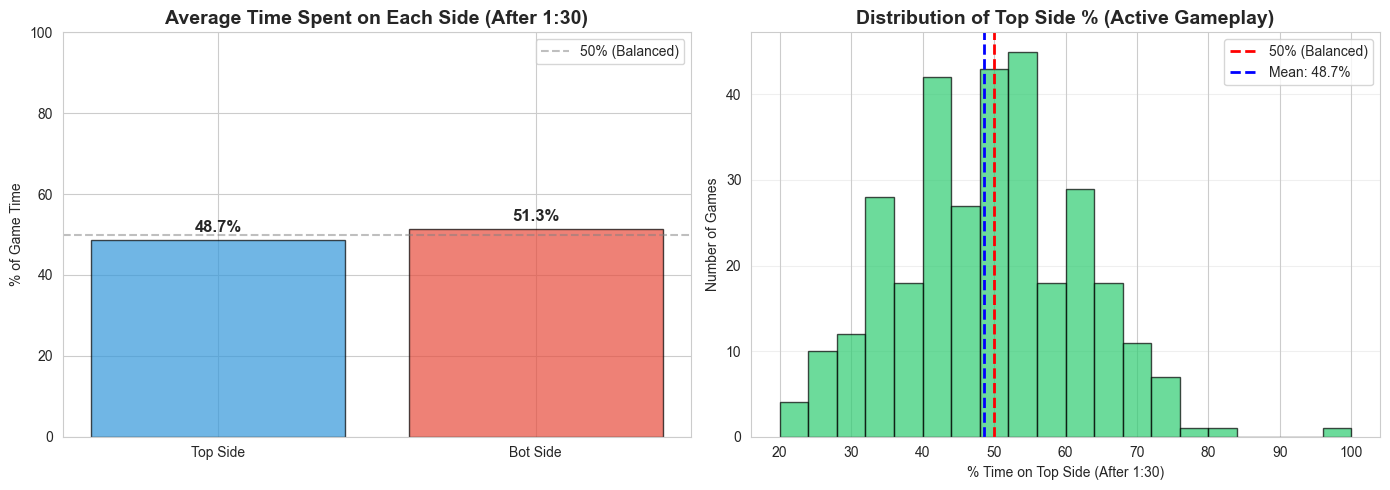


✓ Side preference analysis complete (excluding first 1:30 camp spawn wait)
   Analyzed 315 games with 7,385 active frames


In [258]:
# ============================================================================
# TOP VS BOT SIDE PREFERENCE ANALYSIS (After 1:30)
# ============================================================================

print(f"\n{'='*80}")
print("TOP VS BOT SIDE PREFERENCE (Excluding first 1:30)")
print(f"{'='*80}")

# Filter frames after 1:30 (90 seconds) to exclude jungle camp waiting time
print(f"\n⏱️  Filtering out first 1:30 (camp spawn wait time)...")
active_frames = natty_frames[natty_frames['minute'] >= 1.5].copy()
print(f"   Using {len(active_frames):,} frames (after 1:30) out of {len(natty_frames):,} total")

# Recalculate positioning from active gameplay frames
def calculate_side_percentage(frames):
    """Calculate % time on top vs bot side from position data"""
    # Summoner's Rift map center is approximately at 7435, 7435
    map_center_y = 7435
    
    top_side_frames = len(frames[frames['position_y'] > map_center_y])
    bot_side_frames = len(frames[frames['position_y'] <= map_center_y])
    total = top_side_frames + bot_side_frames
    
    if total == 0:
        return 0, 0
    
    top_pct = (top_side_frames / total) * 100
    bot_pct = (bot_side_frames / total) * 100
    
    return top_pct, bot_pct

# Calculate for all active frames
avg_top_side, avg_bot_side = calculate_side_percentage(active_frames)

print(f"\n📊 Active Gameplay Map Presence (After 1:30):")
print(f"{'─'*60}")
print(f"  Top Side: {avg_top_side:.1f}% of game time")
print(f"  Bot Side: {avg_bot_side:.1f}% of game time")
print(f"  Difference: {abs(avg_top_side - avg_bot_side):.1f}%")
print(f"  Total: {avg_top_side + avg_bot_side:.1f}% (should be 100%)")

if avg_top_side > avg_bot_side:
    print(f"\n✅ NattyNatt prefers TOP SIDE ({avg_top_side:.1f}% vs {avg_bot_side:.1f}%)")
else:
    print(f"\n✅ NattyNatt prefers BOT SIDE ({avg_bot_side:.1f}% vs {avg_top_side:.1f}%)")

# By outcome (using active frames after 1:30)
print(f"\n📈 Map Presence by Outcome (After 1:30):")
print(f"{'─'*60}")
for outcome in [False, True]:
    label = "Wins" if outcome else "Losses"
    outcome_frames = active_frames[active_frames['win'] == outcome]
    top_pct, bot_pct = calculate_side_percentage(outcome_frames)
    print(f"  {label}:")
    print(f"    Top Side: {top_pct:.1f}%")
    print(f"    Bot Side: {bot_pct:.1f}%")
    
# Analyze individual games
print(f"\n🎯 Game Distribution (After 1:30):")
print(f"{'─'*60}")

# Calculate per-game positioning
game_positioning = []
for match_id in active_frames['match_id'].unique():
    game_frames = active_frames[active_frames['match_id'] == match_id]
    top_pct, bot_pct = calculate_side_percentage(game_frames)
    game_positioning.append({'match_id': match_id, 'top_pct': top_pct, 'bot_pct': bot_pct})

game_pos_df = pd.DataFrame(game_positioning)

# Count games with strong preference
top_heavy = len(game_pos_df[game_pos_df['top_pct'] > 55])
bot_heavy = len(game_pos_df[game_pos_df['bot_pct'] > 55])
balanced = len(game_pos_df[(game_pos_df['top_pct'] >= 45) & (game_pos_df['top_pct'] <= 55)])

total_games_analyzed = len(game_pos_df)
print(f"  Top-heavy games (>55% top): {top_heavy} ({top_heavy/total_games_analyzed:.1%})")
print(f"  Bot-heavy games (>55% bot): {bot_heavy} ({bot_heavy/total_games_analyzed:.1%})")
print(f"  Balanced games (45-55%): {balanced} ({balanced/total_games_analyzed:.1%})")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart comparison
sides = ['Top Side', 'Bot Side']
percentages = [avg_top_side, avg_bot_side]  # Already in percentage form (0-100)
colors = ['#3498db', '#e74c3c']

axes[0].bar(sides, percentages, color=colors, alpha=0.7, edgecolor='black')
axes[0].axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='50% (Balanced)')
axes[0].set_ylabel('% of Game Time')
axes[0].set_title('Average Time Spent on Each Side (After 1:30)', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 100)
axes[0].legend()

# Add value labels on bars
for i, (side, pct) in enumerate(zip(sides, percentages)):
    axes[0].text(i, pct + 2, f'{pct:.1f}%', ha='center', fontsize=12, fontweight='bold')

# Distribution of top side % (per-game after 1:30)
axes[1].hist(game_pos_df['top_pct'], bins=20, edgecolor='black', alpha=0.7, color='#2ecc71')
axes[1].axvline(x=50, color='red', linestyle='--', linewidth=2, label='50% (Balanced)')
axes[1].axvline(x=avg_top_side, color='blue', linestyle='--', linewidth=2, label=f'Mean: {avg_top_side:.1f}%')
axes[1].set_xlabel('% Time on Top Side (After 1:30)')
axes[1].set_ylabel('Number of Games')
axes[1].set_title('Distribution of Top Side % (Active Gameplay)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Side preference analysis complete (excluding first 1:30 camp spawn wait)")
print(f"   Analyzed {total_games_analyzed} games with {len(active_frames):,} active frames")
